In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = True

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : False,
    'huntington'    : True,
    'left'          : False,
    'right'         : True,
    'threshold'     : None,
    'binarize'      : False,
    'not_connected' : False,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        #{'sp':'normalized','im':'t1t2','fe':['b25'],'fi':['roi','t1_mask']},
    ],
    'space'         : 'normalized',
    'radiomics_vox' : [
        {'im':'t1t2','fe':['k5_b25','k7_b25','k9_b25','k11_b25','k13_b25','k15_b25','k17_b25','k19_b25','k21_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : [],
    'features_clin' : None,
    'outp'          : 'diffusion_md',
    'balance_data'  : False,
    'exclude'       : ['t1t2','normalized'],
    'include_warp'  : True,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'MSE',
    'learning_rate' : 0.001,
    'batch_size'    : 10000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_10000_1024_512_256_128_0001_MSE_7_0_0_0_0_0_t1t2_normalized_e_n_e_1_1_e_0_0_diffusion_md_data_norm_e_k5_b25_k7_b25_k9_b25_k11_b25_k13_b25_k15_b25_k17_b25_k19_b25_k21_b25_t1t2_1_42_n_normalized_08_05_n


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(346712, 828)
(346712, 1)
validation
(56968, 828)
(56968, 1)
test
(29712, 828)
(29712, 1)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 828)]             0         


 dense (Dense)               (None, 1024)              848896    


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 1)                 129       


Total params: 1538049 (5.87 MB)


Trainable params: 1538049 (5.87 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


 1/35 [..............................] - ETA: 40s - loss: 0.0118 - STD: 9.0177e-05 - MAE: 0.0735

 3/35 [=>............................] - ETA: 9s - loss: 0.0177 - STD: 3.0337e-04 - MAE: 0.0872 

 6/35 [====>.........................] - ETA: 4s - loss: 0.0178 - STD: 7.8914e-04 - MAE: 0.0969

 7/35 [=====>........................] - ETA: 3s - loss: 0.0175 - STD: 8.4068e-04 - MAE: 0.0936

 8/35 [=====>........................] - ETA: 3s - loss: 0.0175 - STD: 8.8613e-04 - MAE: 0.0922

 9/35 [======>.......................] - ETA: 2s - loss: 0.0174 - STD: 9.4201e-04 - MAE: 0.0904

10/35 [=======>......................] - ETA: 2s - loss: 0.0170 - STD: 0.0010 - MAE: 0.0877    

11/35 [========>.....................] - ETA: 2s - loss: 0.0165 - STD: 0.0011 - MAE: 0.0859

12/35 [=========>....................] - ETA: 2s - loss: 0.0162 - STD: 0.0012 - MAE: 0.0859

13/35 [==========>...................] - ETA: 2s - loss: 0.0160 - STD: 0.0013 - MAE: 0.0869

14/35 [===========>..................] - ETA: 2s - loss: 0.0158 - STD: 0.0014 - MAE: 0.0875

15/35 [===========>..................] - ETA: 1s - loss: 0.0156 - STD: 0.0015 - MAE: 0.0873

16/35 [============>.................] - ETA: 1s - loss: 0.0153 - STD: 0.0015 - MAE: 0.0863

17/35 [=============>................] - ETA: 1s - loss: 0.0151 - STD: 0.0016 - MAE: 0.0849

18/35 [==============>...............] - ETA: 1s - loss: 0.0150 - STD: 0.0017 - MAE: 0.0836

19/35 [===============>..............] - ETA: 1s - loss: 0.0149 - STD: 0.0017 - MAE: 0.0824

20/35 [================>.............] - ETA: 1s - loss: 0.0147 - STD: 0.0018 - MAE: 0.0814

21/35 [=================>............] - ETA: 1s - loss: 0.0146 - STD: 0.0018 - MAE: 0.0805

22/35 [=================>............] - ETA: 1s - loss: 0.0145 - STD: 0.0019 - MAE: 0.0797

23/35 [==================>...........] - ETA: 1s - loss: 0.0143 - STD: 0.0020 - MAE: 0.0793

24/35 [===================>..........] - ETA: 0s - loss: 0.0142 - STD: 0.0021 - MAE: 0.0792

25/35 [====================>.........] - ETA: 0s - loss: 0.0141 - STD: 0.0022 - MAE: 0.0793

26/35 [=====================>........] - ETA: 0s - loss: 0.0141 - STD: 0.0023 - MAE: 0.0794

27/35 [======================>.......] - ETA: 0s - loss: 0.0140 - STD: 0.0024 - MAE: 0.0792

28/35 [=======================>......] - ETA: 0s - loss: 0.0139 - STD: 0.0025 - MAE: 0.0789

29/35 [=======================>......] - ETA: 0s - loss: 0.0138 - STD: 0.0026 - MAE: 0.0784

30/35 [========================>.....] - ETA: 0s - loss: 0.0137 - STD: 0.0027 - MAE: 0.0779

31/35 [=========================>....] - ETA: 0s - loss: 0.0137 - STD: 0.0028 - MAE: 0.0774

32/35 [==========================>...] - ETA: 0s - loss: 0.0136 - STD: 0.0029 - MAE: 0.0768

33/35 [===========================>..] - ETA: 0s - loss: 0.0135 - STD: 0.0030 - MAE: 0.0764

34/35 [============================>.] - ETA: 0s - loss: 0.0134 - STD: 0.0031 - MAE: 0.0761

35/35 [==============================] - ETA: 0s - loss: 0.0133 - STD: 0.0033 - MAE: 0.0759

35/35 [==============================] - 5s 98ms/step - loss: 0.0133 - STD: 0.0033 - MAE: 0.0759 - val_loss: 0.0116 - val_STD: 0.0078 - val_MAE: 0.0720


Epoch 2/10000


 1/35 [..............................] - ETA: 3s - loss: 0.0108 - STD: 0.0091 - MAE: 0.0708

 2/35 [>.............................] - ETA: 2s - loss: 0.0108 - STD: 0.0096 - MAE: 0.0711

 3/35 [=>............................] - ETA: 2s - loss: 0.0107 - STD: 0.0100 - MAE: 0.0705

 4/35 [==>...........................] - ETA: 2s - loss: 0.0106 - STD: 0.0104 - MAE: 0.0694

 5/35 [===>..........................] - ETA: 1s - loss: 0.0106 - STD: 0.0108 - MAE: 0.0682

 6/35 [====>.........................] - ETA: 1s - loss: 0.0106 - STD: 0.0112 - MAE: 0.0673

 7/35 [=====>........................] - ETA: 1s - loss: 0.0107 - STD: 0.0117 - MAE: 0.0665

 8/35 [=====>........................] - ETA: 1s - loss: 0.0106 - STD: 0.0123 - MAE: 0.0658

 9/35 [======>.......................] - ETA: 1s - loss: 0.0105 - STD: 0.0129 - MAE: 0.0653

10/35 [=======>......................] - ETA: 1s - loss: 0.0105 - STD: 0.0136 - MAE: 0.0651

11/35 [========>.....................] - ETA: 1s - loss: 0.0104 - STD: 0.0144 - MAE: 0.0651

12/35 [=========>....................] - ETA: 1s - loss: 0.0104 - STD: 0.0152 - MAE: 0.0651

13/35 [==========>...................] - ETA: 1s - loss: 0.0103 - STD: 0.0161 - MAE: 0.0649

14/35 [===========>..................] - ETA: 1s - loss: 0.0102 - STD: 0.0170 - MAE: 0.0647

15/35 [===========>..................] - ETA: 1s - loss: 0.0101 - STD: 0.0179 - MAE: 0.0642

17/35 [=============>................] - ETA: 1s - loss: 0.0100 - STD: 0.0199 - MAE: 0.0634

18/35 [==============>...............] - ETA: 1s - loss: 0.0099 - STD: 0.0211 - MAE: 0.0630

19/35 [===============>..............] - ETA: 1s - loss: 0.0098 - STD: 0.0223 - MAE: 0.0628

20/35 [================>.............] - ETA: 0s - loss: 0.0097 - STD: 0.0236 - MAE: 0.0625

21/35 [=================>............] - ETA: 0s - loss: 0.0096 - STD: 0.0250 - MAE: 0.0623

22/35 [=================>............] - ETA: 0s - loss: 0.0095 - STD: 0.0264 - MAE: 0.0620

23/35 [==================>...........] - ETA: 0s - loss: 0.0094 - STD: 0.0277 - MAE: 0.0617

24/35 [===================>..........] - ETA: 0s - loss: 0.0093 - STD: 0.0290 - MAE: 0.0614

25/35 [====================>.........] - ETA: 0s - loss: 0.0092 - STD: 0.0303 - MAE: 0.0611

26/35 [=====================>........] - ETA: 0s - loss: 0.0091 - STD: 0.0317 - MAE: 0.0608

27/35 [======================>.......] - ETA: 0s - loss: 0.0090 - STD: 0.0331 - MAE: 0.0606

28/35 [=======================>......] - ETA: 0s - loss: 0.0089 - STD: 0.0344 - MAE: 0.0603

29/35 [=======================>......] - ETA: 0s - loss: 0.0088 - STD: 0.0356 - MAE: 0.0600

30/35 [========================>.....] - ETA: 0s - loss: 0.0087 - STD: 0.0367 - MAE: 0.0597

31/35 [=========================>....] - ETA: 0s - loss: 0.0086 - STD: 0.0378 - MAE: 0.0594

32/35 [==========================>...] - ETA: 0s - loss: 0.0085 - STD: 0.0388 - MAE: 0.0591

33/35 [===========================>..] - ETA: 0s - loss: 0.0084 - STD: 0.0398 - MAE: 0.0588

34/35 [============================>.] - ETA: 0s - loss: 0.0083 - STD: 0.0407 - MAE: 0.0585

35/35 [==============================] - ETA: 0s - loss: 0.0083 - STD: 0.0416 - MAE: 0.0582

35/35 [==============================] - 3s 71ms/step - loss: 0.0083 - STD: 0.0416 - MAE: 0.0582 - val_loss: 0.0061 - val_STD: 0.0519 - val_MAE: 0.0511


Epoch 3/10000


 1/35 [..............................] - ETA: 3s - loss: 0.0052 - STD: 0.0697 - MAE: 0.0474

 2/35 [>.............................] - ETA: 2s - loss: 0.0052 - STD: 0.0714 - MAE: 0.0474

 3/35 [=>............................] - ETA: 2s - loss: 0.0052 - STD: 0.0736 - MAE: 0.0476

 4/35 [==>...........................] - ETA: 2s - loss: 0.0052 - STD: 0.0754 - MAE: 0.0478

 5/35 [===>..........................] - ETA: 2s - loss: 0.0052 - STD: 0.0764 - MAE: 0.0478

 6/35 [====>.........................] - ETA: 1s - loss: 0.0052 - STD: 0.0773 - MAE: 0.0477

 7/35 [=====>........................] - ETA: 1s - loss: 0.0052 - STD: 0.0779 - MAE: 0.0476

 8/35 [=====>........................] - ETA: 1s - loss: 0.0052 - STD: 0.0789 - MAE: 0.0476

 9/35 [======>.......................] - ETA: 1s - loss: 0.0052 - STD: 0.0797 - MAE: 0.0475

11/35 [========>.....................] - ETA: 1s - loss: 0.0051 - STD: 0.0806 - MAE: 0.0472

12/35 [=========>....................] - ETA: 1s - loss: 0.0051 - STD: 0.0809 - MAE: 0.0471

13/35 [==========>...................] - ETA: 1s - loss: 0.0051 - STD: 0.0810 - MAE: 0.0470

14/35 [===========>..................] - ETA: 1s - loss: 0.0051 - STD: 0.0810 - MAE: 0.0469

15/35 [===========>..................] - ETA: 1s - loss: 0.0051 - STD: 0.0812 - MAE: 0.0468

16/35 [============>.................] - ETA: 1s - loss: 0.0051 - STD: 0.0810 - MAE: 0.0467

17/35 [=============>................] - ETA: 1s - loss: 0.0050 - STD: 0.0811 - MAE: 0.0467

18/35 [==============>...............] - ETA: 1s - loss: 0.0050 - STD: 0.0811 - MAE: 0.0466

19/35 [===============>..............] - ETA: 1s - loss: 0.0050 - STD: 0.0813 - MAE: 0.0465

20/35 [================>.............] - ETA: 0s - loss: 0.0050 - STD: 0.0815 - MAE: 0.0465

21/35 [=================>............] - ETA: 0s - loss: 0.0050 - STD: 0.0816 - MAE: 0.0465

22/35 [=================>............] - ETA: 0s - loss: 0.0050 - STD: 0.0818 - MAE: 0.0464

23/35 [==================>...........] - ETA: 0s - loss: 0.0050 - STD: 0.0820 - MAE: 0.0463

24/35 [===================>..........] - ETA: 0s - loss: 0.0050 - STD: 0.0822 - MAE: 0.0463

25/35 [====================>.........] - ETA: 0s - loss: 0.0050 - STD: 0.0824 - MAE: 0.0462

26/35 [=====================>........] - ETA: 0s - loss: 0.0050 - STD: 0.0825 - MAE: 0.0462

27/35 [======================>.......] - ETA: 0s - loss: 0.0049 - STD: 0.0825 - MAE: 0.0461

28/35 [=======================>......] - ETA: 0s - loss: 0.0049 - STD: 0.0826 - MAE: 0.0460

29/35 [=======================>......] - ETA: 0s - loss: 0.0049 - STD: 0.0827 - MAE: 0.0460

30/35 [========================>.....] - ETA: 0s - loss: 0.0049 - STD: 0.0828 - MAE: 0.0459

31/35 [=========================>....] - ETA: 0s - loss: 0.0049 - STD: 0.0828 - MAE: 0.0458

32/35 [==========================>...] - ETA: 0s - loss: 0.0049 - STD: 0.0828 - MAE: 0.0458

33/35 [===========================>..] - ETA: 0s - loss: 0.0049 - STD: 0.0828 - MAE: 0.0457

34/35 [============================>.] - ETA: 0s - loss: 0.0049 - STD: 0.0829 - MAE: 0.0457

35/35 [==============================] - ETA: 0s - loss: 0.0048 - STD: 0.0830 - MAE: 0.0456

35/35 [==============================] - 2s 69ms/step - loss: 0.0048 - STD: 0.0830 - MAE: 0.0456 - val_loss: 0.0079 - val_STD: 0.0715 - val_MAE: 0.0604


Epoch 4/10000


 1/35 [..............................] - ETA: 3s - loss: 0.0043 - STD: 0.0861 - MAE: 0.0433

 2/35 [>.............................] - ETA: 2s - loss: 0.0045 - STD: 0.0841 - MAE: 0.0435

 3/35 [=>............................] - ETA: 2s - loss: 0.0045 - STD: 0.0841 - MAE: 0.0437

 4/35 [==>...........................] - ETA: 2s - loss: 0.0046 - STD: 0.0851 - MAE: 0.0442

 5/35 [===>..........................] - ETA: 1s - loss: 0.0046 - STD: 0.0855 - MAE: 0.0443

 6/35 [====>.........................] - ETA: 1s - loss: 0.0045 - STD: 0.0843 - MAE: 0.0441

 7/35 [=====>........................] - ETA: 1s - loss: 0.0045 - STD: 0.0836 - MAE: 0.0438

 8/35 [=====>........................] - ETA: 1s - loss: 0.0045 - STD: 0.0837 - MAE: 0.0439

 9/35 [======>.......................] - ETA: 1s - loss: 0.0045 - STD: 0.0843 - MAE: 0.0440

10/35 [=======>......................] - ETA: 1s - loss: 0.0045 - STD: 0.0844 - MAE: 0.0439

11/35 [========>.....................] - ETA: 1s - loss: 0.0045 - STD: 0.0842 - MAE: 0.0439

12/35 [=========>....................] - ETA: 1s - loss: 0.0045 - STD: 0.0842 - MAE: 0.0438

13/35 [==========>...................] - ETA: 1s - loss: 0.0045 - STD: 0.0849 - MAE: 0.0439

14/35 [===========>..................] - ETA: 1s - loss: 0.0045 - STD: 0.0852 - MAE: 0.0439

15/35 [===========>..................] - ETA: 1s - loss: 0.0045 - STD: 0.0852 - MAE: 0.0438

16/35 [============>.................] - ETA: 1s - loss: 0.0045 - STD: 0.0851 - MAE: 0.0438

17/35 [=============>................] - ETA: 1s - loss: 0.0045 - STD: 0.0853 - MAE: 0.0438

18/35 [==============>...............] - ETA: 1s - loss: 0.0045 - STD: 0.0858 - MAE: 0.0439

19/35 [===============>..............] - ETA: 1s - loss: 0.0044 - STD: 0.0856 - MAE: 0.0437

20/35 [================>.............] - ETA: 0s - loss: 0.0044 - STD: 0.0853 - MAE: 0.0437

21/35 [=================>............] - ETA: 0s - loss: 0.0044 - STD: 0.0852 - MAE: 0.0437

22/35 [=================>............] - ETA: 0s - loss: 0.0044 - STD: 0.0855 - MAE: 0.0438

24/35 [===================>..........] - ETA: 0s - loss: 0.0044 - STD: 0.0853 - MAE: 0.0438

25/35 [====================>.........] - ETA: 0s - loss: 0.0044 - STD: 0.0851 - MAE: 0.0438

26/35 [=====================>........] - ETA: 0s - loss: 0.0044 - STD: 0.0852 - MAE: 0.0438

27/35 [======================>.......] - ETA: 0s - loss: 0.0044 - STD: 0.0855 - MAE: 0.0438

28/35 [=======================>......] - ETA: 0s - loss: 0.0044 - STD: 0.0854 - MAE: 0.0437

29/35 [=======================>......] - ETA: 0s - loss: 0.0044 - STD: 0.0852 - MAE: 0.0437

30/35 [========================>.....] - ETA: 0s - loss: 0.0044 - STD: 0.0852 - MAE: 0.0437

31/35 [=========================>....] - ETA: 0s - loss: 0.0044 - STD: 0.0854 - MAE: 0.0437

32/35 [==========================>...] - ETA: 0s - loss: 0.0044 - STD: 0.0855 - MAE: 0.0437

33/35 [===========================>..] - ETA: 0s - loss: 0.0044 - STD: 0.0854 - MAE: 0.0436

34/35 [============================>.] - ETA: 0s - loss: 0.0044 - STD: 0.0854 - MAE: 0.0436

35/35 [==============================] - ETA: 0s - loss: 0.0044 - STD: 0.0855 - MAE: 0.0436

35/35 [==============================] - 2s 70ms/step - loss: 0.0044 - STD: 0.0855 - MAE: 0.0436 - val_loss: 0.0097 - val_STD: 0.0775 - val_MAE: 0.0676


Epoch 5/10000


 1/35 [..............................] - ETA: 3s - loss: 0.0042 - STD: 0.0879 - MAE: 0.0436

 2/35 [>.............................] - ETA: 2s - loss: 0.0042 - STD: 0.0858 - MAE: 0.0428

 3/35 [=>............................] - ETA: 2s - loss: 0.0043 - STD: 0.0843 - MAE: 0.0427

 4/35 [==>...........................] - ETA: 2s - loss: 0.0043 - STD: 0.0851 - MAE: 0.0427

 5/35 [===>..........................] - ETA: 1s - loss: 0.0043 - STD: 0.0858 - MAE: 0.0430

 6/35 [====>.........................] - ETA: 1s - loss: 0.0043 - STD: 0.0866 - MAE: 0.0430

 7/35 [=====>........................] - ETA: 1s - loss: 0.0043 - STD: 0.0860 - MAE: 0.0429

 9/35 [======>.......................] - ETA: 1s - loss: 0.0043 - STD: 0.0865 - MAE: 0.0429

10/35 [=======>......................] - ETA: 1s - loss: 0.0043 - STD: 0.0870 - MAE: 0.0430

11/35 [========>.....................] - ETA: 1s - loss: 0.0043 - STD: 0.0865 - MAE: 0.0429

12/35 [=========>....................] - ETA: 1s - loss: 0.0043 - STD: 0.0864 - MAE: 0.0429

13/35 [==========>...................] - ETA: 1s - loss: 0.0043 - STD: 0.0865 - MAE: 0.0429

14/35 [===========>..................] - ETA: 1s - loss: 0.0043 - STD: 0.0867 - MAE: 0.0430

15/35 [===========>..................] - ETA: 1s - loss: 0.0043 - STD: 0.0866 - MAE: 0.0429

16/35 [============>.................] - ETA: 1s - loss: 0.0043 - STD: 0.0864 - MAE: 0.0429

17/35 [=============>................] - ETA: 1s - loss: 0.0043 - STD: 0.0865 - MAE: 0.0429

18/35 [==============>...............] - ETA: 1s - loss: 0.0043 - STD: 0.0868 - MAE: 0.0430

19/35 [===============>..............] - ETA: 0s - loss: 0.0043 - STD: 0.0868 - MAE: 0.0429

20/35 [================>.............] - ETA: 0s - loss: 0.0043 - STD: 0.0866 - MAE: 0.0428

21/35 [=================>............] - ETA: 0s - loss: 0.0043 - STD: 0.0864 - MAE: 0.0428

22/35 [=================>............] - ETA: 0s - loss: 0.0043 - STD: 0.0866 - MAE: 0.0429

23/35 [==================>...........] - ETA: 0s - loss: 0.0043 - STD: 0.0868 - MAE: 0.0429

24/35 [===================>..........] - ETA: 0s - loss: 0.0043 - STD: 0.0867 - MAE: 0.0429

25/35 [====================>.........] - ETA: 0s - loss: 0.0043 - STD: 0.0865 - MAE: 0.0429

26/35 [=====================>........] - ETA: 0s - loss: 0.0043 - STD: 0.0866 - MAE: 0.0429

27/35 [======================>.......] - ETA: 0s - loss: 0.0043 - STD: 0.0868 - MAE: 0.0429

28/35 [=======================>......] - ETA: 0s - loss: 0.0043 - STD: 0.0869 - MAE: 0.0429

29/35 [=======================>......] - ETA: 0s - loss: 0.0043 - STD: 0.0867 - MAE: 0.0429

30/35 [========================>.....] - ETA: 0s - loss: 0.0043 - STD: 0.0867 - MAE: 0.0428

31/35 [=========================>....] - ETA: 0s - loss: 0.0043 - STD: 0.0869 - MAE: 0.0429

32/35 [==========================>...] - ETA: 0s - loss: 0.0043 - STD: 0.0868 - MAE: 0.0428

33/35 [===========================>..] - ETA: 0s - loss: 0.0043 - STD: 0.0867 - MAE: 0.0428

34/35 [============================>.] - ETA: 0s - loss: 0.0043 - STD: 0.0866 - MAE: 0.0428

35/35 [==============================] - ETA: 0s - loss: 0.0043 - STD: 0.0868 - MAE: 0.0428

35/35 [==============================] - 2s 67ms/step - loss: 0.0043 - STD: 0.0868 - MAE: 0.0428 - val_loss: 0.0089 - val_STD: 0.0777 - val_MAE: 0.0641


Epoch 6/10000


 1/35 [..............................] - ETA: 3s - loss: 0.0039 - STD: 0.0848 - MAE: 0.0414

 2/35 [>.............................] - ETA: 2s - loss: 0.0041 - STD: 0.0854 - MAE: 0.0418

 3/35 [=>............................] - ETA: 2s - loss: 0.0041 - STD: 0.0866 - MAE: 0.0418

 4/35 [==>...........................] - ETA: 2s - loss: 0.0041 - STD: 0.0874 - MAE: 0.0419

 5/35 [===>..........................] - ETA: 2s - loss: 0.0041 - STD: 0.0872 - MAE: 0.0418

 6/35 [====>.........................] - ETA: 1s - loss: 0.0041 - STD: 0.0876 - MAE: 0.0418

 7/35 [=====>........................] - ETA: 1s - loss: 0.0041 - STD: 0.0879 - MAE: 0.0417

 8/35 [=====>........................] - ETA: 1s - loss: 0.0041 - STD: 0.0880 - MAE: 0.0418

 9/35 [======>.......................] - ETA: 1s - loss: 0.0041 - STD: 0.0880 - MAE: 0.0418

10/35 [=======>......................] - ETA: 1s - loss: 0.0041 - STD: 0.0877 - MAE: 0.0418

11/35 [========>.....................] - ETA: 1s - loss: 0.0041 - STD: 0.0874 - MAE: 0.0418

12/35 [=========>....................] - ETA: 1s - loss: 0.0041 - STD: 0.0872 - MAE: 0.0418

13/35 [==========>...................] - ETA: 1s - loss: 0.0041 - STD: 0.0869 - MAE: 0.0418

14/35 [===========>..................] - ETA: 1s - loss: 0.0041 - STD: 0.0870 - MAE: 0.0418

15/35 [===========>..................] - ETA: 1s - loss: 0.0041 - STD: 0.0869 - MAE: 0.0419

16/35 [============>.................] - ETA: 1s - loss: 0.0041 - STD: 0.0870 - MAE: 0.0418

18/35 [==============>...............] - ETA: 1s - loss: 0.0041 - STD: 0.0873 - MAE: 0.0418

19/35 [===============>..............] - ETA: 1s - loss: 0.0041 - STD: 0.0874 - MAE: 0.0419

20/35 [================>.............] - ETA: 0s - loss: 0.0041 - STD: 0.0874 - MAE: 0.0418

21/35 [=================>............] - ETA: 0s - loss: 0.0041 - STD: 0.0873 - MAE: 0.0418

22/35 [=================>............] - ETA: 0s - loss: 0.0041 - STD: 0.0873 - MAE: 0.0418

23/35 [==================>...........] - ETA: 0s - loss: 0.0041 - STD: 0.0874 - MAE: 0.0418

24/35 [===================>..........] - ETA: 0s - loss: 0.0041 - STD: 0.0875 - MAE: 0.0418

25/35 [====================>.........] - ETA: 0s - loss: 0.0041 - STD: 0.0874 - MAE: 0.0418

26/35 [=====================>........] - ETA: 0s - loss: 0.0041 - STD: 0.0874 - MAE: 0.0418

27/35 [======================>.......] - ETA: 0s - loss: 0.0041 - STD: 0.0875 - MAE: 0.0418

28/35 [=======================>......] - ETA: 0s - loss: 0.0041 - STD: 0.0875 - MAE: 0.0418

29/35 [=======================>......] - ETA: 0s - loss: 0.0041 - STD: 0.0875 - MAE: 0.0418

30/35 [========================>.....] - ETA: 0s - loss: 0.0041 - STD: 0.0876 - MAE: 0.0418

31/35 [=========================>....] - ETA: 0s - loss: 0.0041 - STD: 0.0876 - MAE: 0.0418

32/35 [==========================>...] - ETA: 0s - loss: 0.0041 - STD: 0.0876 - MAE: 0.0418

33/35 [===========================>..] - ETA: 0s - loss: 0.0041 - STD: 0.0876 - MAE: 0.0417

34/35 [============================>.] - ETA: 0s - loss: 0.0041 - STD: 0.0876 - MAE: 0.0417

35/35 [==============================] - ETA: 0s - loss: 0.0041 - STD: 0.0876 - MAE: 0.0417

35/35 [==============================] - 2s 69ms/step - loss: 0.0041 - STD: 0.0876 - MAE: 0.0417 - val_loss: 0.0081 - val_STD: 0.0773 - val_MAE: 0.0611


Epoch 7/10000


 1/35 [..............................] - ETA: 3s - loss: 0.0039 - STD: 0.0846 - MAE: 0.0407

 2/35 [>.............................] - ETA: 2s - loss: 0.0040 - STD: 0.0868 - MAE: 0.0412

 3/35 [=>............................] - ETA: 2s - loss: 0.0040 - STD: 0.0875 - MAE: 0.0412

 4/35 [==>...........................] - ETA: 2s - loss: 0.0040 - STD: 0.0866 - MAE: 0.0414

 5/35 [===>..........................] - ETA: 1s - loss: 0.0040 - STD: 0.0867 - MAE: 0.0413

 6/35 [====>.........................] - ETA: 1s - loss: 0.0040 - STD: 0.0875 - MAE: 0.0416

 7/35 [=====>........................] - ETA: 1s - loss: 0.0040 - STD: 0.0870 - MAE: 0.0414

 8/35 [=====>........................] - ETA: 1s - loss: 0.0040 - STD: 0.0868 - MAE: 0.0415

 9/35 [======>.......................] - ETA: 1s - loss: 0.0041 - STD: 0.0875 - MAE: 0.0417

10/35 [=======>......................] - ETA: 1s - loss: 0.0041 - STD: 0.0879 - MAE: 0.0417

11/35 [========>.....................] - ETA: 1s - loss: 0.0041 - STD: 0.0877 - MAE: 0.0416

12/35 [=========>....................] - ETA: 1s - loss: 0.0041 - STD: 0.0876 - MAE: 0.0416

13/35 [==========>...................] - ETA: 1s - loss: 0.0040 - STD: 0.0878 - MAE: 0.0416

14/35 [===========>..................] - ETA: 1s - loss: 0.0041 - STD: 0.0878 - MAE: 0.0416

15/35 [===========>..................] - ETA: 1s - loss: 0.0041 - STD: 0.0877 - MAE: 0.0416

16/35 [============>.................] - ETA: 1s - loss: 0.0040 - STD: 0.0877 - MAE: 0.0415

17/35 [=============>................] - ETA: 1s - loss: 0.0041 - STD: 0.0881 - MAE: 0.0416

18/35 [==============>...............] - ETA: 1s - loss: 0.0041 - STD: 0.0880 - MAE: 0.0415

19/35 [===============>..............] - ETA: 1s - loss: 0.0041 - STD: 0.0879 - MAE: 0.0415

20/35 [================>.............] - ETA: 0s - loss: 0.0040 - STD: 0.0880 - MAE: 0.0415

21/35 [=================>............] - ETA: 0s - loss: 0.0040 - STD: 0.0881 - MAE: 0.0416

22/35 [=================>............] - ETA: 0s - loss: 0.0040 - STD: 0.0879 - MAE: 0.0415

23/35 [==================>...........] - ETA: 0s - loss: 0.0040 - STD: 0.0879 - MAE: 0.0415

25/35 [====================>.........] - ETA: 0s - loss: 0.0040 - STD: 0.0880 - MAE: 0.0415

26/35 [=====================>........] - ETA: 0s - loss: 0.0040 - STD: 0.0879 - MAE: 0.0415

27/35 [======================>.......] - ETA: 0s - loss: 0.0040 - STD: 0.0879 - MAE: 0.0414

28/35 [=======================>......] - ETA: 0s - loss: 0.0040 - STD: 0.0880 - MAE: 0.0415

29/35 [=======================>......] - ETA: 0s - loss: 0.0040 - STD: 0.0880 - MAE: 0.0415

30/35 [========================>.....] - ETA: 0s - loss: 0.0040 - STD: 0.0878 - MAE: 0.0414

31/35 [=========================>....] - ETA: 0s - loss: 0.0040 - STD: 0.0879 - MAE: 0.0414

32/35 [==========================>...] - ETA: 0s - loss: 0.0040 - STD: 0.0879 - MAE: 0.0414

33/35 [===========================>..] - ETA: 0s - loss: 0.0040 - STD: 0.0879 - MAE: 0.0414

34/35 [============================>.] - ETA: 0s - loss: 0.0040 - STD: 0.0879 - MAE: 0.0413

35/35 [==============================] - ETA: 0s - loss: 0.0040 - STD: 0.0880 - MAE: 0.0414

35/35 [==============================] - 2s 68ms/step - loss: 0.0040 - STD: 0.0880 - MAE: 0.0414 - val_loss: 0.0076 - val_STD: 0.0797 - val_MAE: 0.0598


Epoch 8/10000


 1/35 [..............................] - ETA: 3s - loss: 0.0038 - STD: 0.0880 - MAE: 0.0401

 2/35 [>.............................] - ETA: 2s - loss: 0.0039 - STD: 0.0862 - MAE: 0.0404

 3/35 [=>............................] - ETA: 2s - loss: 0.0039 - STD: 0.0878 - MAE: 0.0405

 5/35 [===>..........................] - ETA: 1s - loss: 0.0039 - STD: 0.0882 - MAE: 0.0405

 6/35 [====>.........................] - ETA: 1s - loss: 0.0039 - STD: 0.0881 - MAE: 0.0405

 7/35 [=====>........................] - ETA: 1s - loss: 0.0039 - STD: 0.0887 - MAE: 0.0408

 8/35 [=====>........................] - ETA: 1s - loss: 0.0039 - STD: 0.0890 - MAE: 0.0408

 9/35 [======>.......................] - ETA: 1s - loss: 0.0039 - STD: 0.0887 - MAE: 0.0407

10/35 [=======>......................] - ETA: 1s - loss: 0.0039 - STD: 0.0887 - MAE: 0.0407

11/35 [========>.....................] - ETA: 1s - loss: 0.0039 - STD: 0.0894 - MAE: 0.0409

12/35 [=========>....................] - ETA: 1s - loss: 0.0040 - STD: 0.0891 - MAE: 0.0409

13/35 [==========>...................] - ETA: 1s - loss: 0.0039 - STD: 0.0891 - MAE: 0.0408

14/35 [===========>..................] - ETA: 1s - loss: 0.0039 - STD: 0.0892 - MAE: 0.0409

15/35 [===========>..................] - ETA: 1s - loss: 0.0039 - STD: 0.0891 - MAE: 0.0409

16/35 [============>.................] - ETA: 1s - loss: 0.0039 - STD: 0.0888 - MAE: 0.0408

17/35 [=============>................] - ETA: 1s - loss: 0.0039 - STD: 0.0888 - MAE: 0.0407

18/35 [==============>...............] - ETA: 1s - loss: 0.0039 - STD: 0.0888 - MAE: 0.0407

19/35 [===============>..............] - ETA: 1s - loss: 0.0039 - STD: 0.0885 - MAE: 0.0407

20/35 [================>.............] - ETA: 0s - loss: 0.0039 - STD: 0.0885 - MAE: 0.0407

21/35 [=================>............] - ETA: 0s - loss: 0.0039 - STD: 0.0886 - MAE: 0.0407

22/35 [=================>............] - ETA: 0s - loss: 0.0039 - STD: 0.0885 - MAE: 0.0406

23/35 [==================>...........] - ETA: 0s - loss: 0.0039 - STD: 0.0887 - MAE: 0.0406

24/35 [===================>..........] - ETA: 0s - loss: 0.0039 - STD: 0.0888 - MAE: 0.0406

25/35 [====================>.........] - ETA: 0s - loss: 0.0039 - STD: 0.0888 - MAE: 0.0406

26/35 [=====================>........] - ETA: 0s - loss: 0.0039 - STD: 0.0888 - MAE: 0.0406

27/35 [======================>.......] - ETA: 0s - loss: 0.0039 - STD: 0.0890 - MAE: 0.0406

28/35 [=======================>......] - ETA: 0s - loss: 0.0039 - STD: 0.0890 - MAE: 0.0406

29/35 [=======================>......] - ETA: 0s - loss: 0.0039 - STD: 0.0889 - MAE: 0.0406

30/35 [========================>.....] - ETA: 0s - loss: 0.0039 - STD: 0.0889 - MAE: 0.0406

31/35 [=========================>....] - ETA: 0s - loss: 0.0039 - STD: 0.0887 - MAE: 0.0405

32/35 [==========================>...] - ETA: 0s - loss: 0.0039 - STD: 0.0887 - MAE: 0.0405

33/35 [===========================>..] - ETA: 0s - loss: 0.0039 - STD: 0.0888 - MAE: 0.0405

34/35 [============================>.] - ETA: 0s - loss: 0.0039 - STD: 0.0888 - MAE: 0.0405

35/35 [==============================] - ETA: 0s - loss: 0.0039 - STD: 0.0887 - MAE: 0.0405

35/35 [==============================] - 2s 69ms/step - loss: 0.0039 - STD: 0.0887 - MAE: 0.0405 - val_loss: 0.0073 - val_STD: 0.0822 - val_MAE: 0.0592


Epoch 9/10000


 1/35 [..............................] - ETA: 3s - loss: 0.0040 - STD: 0.0926 - MAE: 0.0414

 2/35 [>.............................] - ETA: 2s - loss: 0.0039 - STD: 0.0914 - MAE: 0.0405

 3/35 [=>............................] - ETA: 2s - loss: 0.0039 - STD: 0.0915 - MAE: 0.0406

 4/35 [==>...........................] - ETA: 2s - loss: 0.0039 - STD: 0.0911 - MAE: 0.0406

 5/35 [===>..........................] - ETA: 2s - loss: 0.0038 - STD: 0.0902 - MAE: 0.0402

 6/35 [====>.........................] - ETA: 1s - loss: 0.0038 - STD: 0.0897 - MAE: 0.0400

 7/35 [=====>........................] - ETA: 1s - loss: 0.0038 - STD: 0.0895 - MAE: 0.0401

 8/35 [=====>........................] - ETA: 1s - loss: 0.0038 - STD: 0.0896 - MAE: 0.0401

 9/35 [======>.......................] - ETA: 1s - loss: 0.0038 - STD: 0.0891 - MAE: 0.0401

10/35 [=======>......................] - ETA: 1s - loss: 0.0038 - STD: 0.0891 - MAE: 0.0401

11/35 [========>.....................] - ETA: 1s - loss: 0.0038 - STD: 0.0892 - MAE: 0.0400

12/35 [=========>....................] - ETA: 1s - loss: 0.0038 - STD: 0.0890 - MAE: 0.0399

13/35 [==========>...................] - ETA: 1s - loss: 0.0038 - STD: 0.0890 - MAE: 0.0399

14/35 [===========>..................] - ETA: 1s - loss: 0.0038 - STD: 0.0891 - MAE: 0.0399

16/35 [============>.................] - ETA: 1s - loss: 0.0037 - STD: 0.0889 - MAE: 0.0397

17/35 [=============>................] - ETA: 1s - loss: 0.0037 - STD: 0.0888 - MAE: 0.0397

18/35 [==============>...............] - ETA: 1s - loss: 0.0037 - STD: 0.0889 - MAE: 0.0397

19/35 [===============>..............] - ETA: 1s - loss: 0.0037 - STD: 0.0892 - MAE: 0.0397

20/35 [================>.............] - ETA: 0s - loss: 0.0037 - STD: 0.0891 - MAE: 0.0397

21/35 [=================>............] - ETA: 0s - loss: 0.0037 - STD: 0.0892 - MAE: 0.0397

22/35 [=================>............] - ETA: 0s - loss: 0.0037 - STD: 0.0892 - MAE: 0.0398

23/35 [==================>...........] - ETA: 0s - loss: 0.0037 - STD: 0.0890 - MAE: 0.0397

24/35 [===================>..........] - ETA: 0s - loss: 0.0037 - STD: 0.0891 - MAE: 0.0398

25/35 [====================>.........] - ETA: 0s - loss: 0.0038 - STD: 0.0890 - MAE: 0.0398

26/35 [=====================>........] - ETA: 0s - loss: 0.0037 - STD: 0.0890 - MAE: 0.0398

27/35 [======================>.......] - ETA: 0s - loss: 0.0037 - STD: 0.0891 - MAE: 0.0398

28/35 [=======================>......] - ETA: 0s - loss: 0.0037 - STD: 0.0892 - MAE: 0.0398

29/35 [=======================>......] - ETA: 0s - loss: 0.0037 - STD: 0.0892 - MAE: 0.0398

30/35 [========================>.....] - ETA: 0s - loss: 0.0037 - STD: 0.0894 - MAE: 0.0398

31/35 [=========================>....] - ETA: 0s - loss: 0.0038 - STD: 0.0892 - MAE: 0.0398

32/35 [==========================>...] - ETA: 0s - loss: 0.0038 - STD: 0.0893 - MAE: 0.0399

33/35 [===========================>..] - ETA: 0s - loss: 0.0038 - STD: 0.0893 - MAE: 0.0399

34/35 [============================>.] - ETA: 0s - loss: 0.0038 - STD: 0.0892 - MAE: 0.0399

35/35 [==============================] - ETA: 0s - loss: 0.0038 - STD: 0.0894 - MAE: 0.0400

35/35 [==============================] - 3s 71ms/step - loss: 0.0038 - STD: 0.0894 - MAE: 0.0400 - val_loss: 0.0055 - val_STD: 0.0724 - val_MAE: 0.0484


Epoch 10/10000


 1/35 [..............................] - ETA: 3s - loss: 0.0042 - STD: 0.0813 - MAE: 0.0417

 2/35 [>.............................] - ETA: 2s - loss: 0.0040 - STD: 0.0871 - MAE: 0.0413

 3/35 [=>............................] - ETA: 2s - loss: 0.0039 - STD: 0.0882 - MAE: 0.0413

 4/35 [==>...........................] - ETA: 2s - loss: 0.0039 - STD: 0.0870 - MAE: 0.0409

 5/35 [===>..........................] - ETA: 1s - loss: 0.0039 - STD: 0.0878 - MAE: 0.0410

 6/35 [====>.........................] - ETA: 1s - loss: 0.0038 - STD: 0.0879 - MAE: 0.0406

 7/35 [=====>........................] - ETA: 1s - loss: 0.0038 - STD: 0.0875 - MAE: 0.0404

 8/35 [=====>........................] - ETA: 1s - loss: 0.0038 - STD: 0.0881 - MAE: 0.0405

 9/35 [======>.......................] - ETA: 1s - loss: 0.0038 - STD: 0.0886 - MAE: 0.0405

10/35 [=======>......................] - ETA: 1s - loss: 0.0038 - STD: 0.0883 - MAE: 0.0404

11/35 [========>.....................] - ETA: 1s - loss: 0.0038 - STD: 0.0885 - MAE: 0.0404

12/35 [=========>....................] - ETA: 1s - loss: 0.0038 - STD: 0.0884 - MAE: 0.0404

13/35 [==========>...................] - ETA: 1s - loss: 0.0038 - STD: 0.0883 - MAE: 0.0402

14/35 [===========>..................] - ETA: 1s - loss: 0.0038 - STD: 0.0885 - MAE: 0.0402

15/35 [===========>..................] - ETA: 1s - loss: 0.0038 - STD: 0.0885 - MAE: 0.0402

16/35 [============>.................] - ETA: 1s - loss: 0.0038 - STD: 0.0886 - MAE: 0.0401

17/35 [=============>................] - ETA: 1s - loss: 0.0038 - STD: 0.0887 - MAE: 0.0400

18/35 [==============>...............] - ETA: 1s - loss: 0.0038 - STD: 0.0890 - MAE: 0.0400

19/35 [===============>..............] - ETA: 1s - loss: 0.0038 - STD: 0.0888 - MAE: 0.0399

20/35 [================>.............] - ETA: 1s - loss: 0.0038 - STD: 0.0890 - MAE: 0.0399

21/35 [=================>............] - ETA: 0s - loss: 0.0038 - STD: 0.0889 - MAE: 0.0399

22/35 [=================>............] - ETA: 0s - loss: 0.0037 - STD: 0.0890 - MAE: 0.0398

23/35 [==================>...........] - ETA: 0s - loss: 0.0037 - STD: 0.0890 - MAE: 0.0398

24/35 [===================>..........] - ETA: 0s - loss: 0.0037 - STD: 0.0889 - MAE: 0.0398

25/35 [====================>.........] - ETA: 0s - loss: 0.0037 - STD: 0.0891 - MAE: 0.0398

26/35 [=====================>........] - ETA: 0s - loss: 0.0037 - STD: 0.0891 - MAE: 0.0398

27/35 [======================>.......] - ETA: 0s - loss: 0.0037 - STD: 0.0892 - MAE: 0.0398

28/35 [=======================>......] - ETA: 0s - loss: 0.0037 - STD: 0.0893 - MAE: 0.0398

29/35 [=======================>......] - ETA: 0s - loss: 0.0037 - STD: 0.0893 - MAE: 0.0397

30/35 [========================>.....] - ETA: 0s - loss: 0.0037 - STD: 0.0894 - MAE: 0.0397

31/35 [=========================>....] - ETA: 0s - loss: 0.0037 - STD: 0.0894 - MAE: 0.0397

32/35 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0894 - MAE: 0.0397

33/35 [===========================>..] - ETA: 0s - loss: 0.0037 - STD: 0.0896 - MAE: 0.0397

34/35 [============================>.] - ETA: 0s - loss: 0.0037 - STD: 0.0895 - MAE: 0.0397

35/35 [==============================] - ETA: 0s - loss: 0.0037 - STD: 0.0896 - MAE: 0.0396

35/35 [==============================] - 3s 71ms/step - loss: 0.0037 - STD: 0.0896 - MAE: 0.0396 - val_loss: 0.0059 - val_STD: 0.0824 - val_MAE: 0.0526


Epoch 11/10000


 1/35 [..............................] - ETA: 3s - loss: 0.0035 - STD: 0.0917 - MAE: 0.0389

 2/35 [>.............................] - ETA: 2s - loss: 0.0035 - STD: 0.0902 - MAE: 0.0390

 3/35 [=>............................] - ETA: 2s - loss: 0.0036 - STD: 0.0909 - MAE: 0.0392

 4/35 [==>...........................] - ETA: 1s - loss: 0.0036 - STD: 0.0910 - MAE: 0.0395

 5/35 [===>..........................] - ETA: 1s - loss: 0.0036 - STD: 0.0895 - MAE: 0.0393

 6/35 [====>.........................] - ETA: 1s - loss: 0.0036 - STD: 0.0900 - MAE: 0.0394

 7/35 [=====>........................] - ETA: 1s - loss: 0.0036 - STD: 0.0900 - MAE: 0.0393

 8/35 [=====>........................] - ETA: 1s - loss: 0.0036 - STD: 0.0899 - MAE: 0.0393

 9/35 [======>.......................] - ETA: 1s - loss: 0.0036 - STD: 0.0905 - MAE: 0.0395

10/35 [=======>......................] - ETA: 1s - loss: 0.0037 - STD: 0.0901 - MAE: 0.0396

11/35 [========>.....................] - ETA: 1s - loss: 0.0037 - STD: 0.0903 - MAE: 0.0398

12/35 [=========>....................] - ETA: 1s - loss: 0.0037 - STD: 0.0896 - MAE: 0.0398

13/35 [==========>...................] - ETA: 1s - loss: 0.0037 - STD: 0.0895 - MAE: 0.0397

14/35 [===========>..................] - ETA: 1s - loss: 0.0037 - STD: 0.0896 - MAE: 0.0398

16/35 [============>.................] - ETA: 1s - loss: 0.0037 - STD: 0.0894 - MAE: 0.0400

17/35 [=============>................] - ETA: 1s - loss: 0.0037 - STD: 0.0894 - MAE: 0.0399

18/35 [==============>...............] - ETA: 1s - loss: 0.0037 - STD: 0.0893 - MAE: 0.0398

19/35 [===============>..............] - ETA: 1s - loss: 0.0037 - STD: 0.0896 - MAE: 0.0399

20/35 [================>.............] - ETA: 0s - loss: 0.0037 - STD: 0.0896 - MAE: 0.0399

21/35 [=================>............] - ETA: 0s - loss: 0.0037 - STD: 0.0893 - MAE: 0.0398

22/35 [=================>............] - ETA: 0s - loss: 0.0037 - STD: 0.0895 - MAE: 0.0399

23/35 [==================>...........] - ETA: 0s - loss: 0.0037 - STD: 0.0893 - MAE: 0.0399

24/35 [===================>..........] - ETA: 0s - loss: 0.0037 - STD: 0.0893 - MAE: 0.0398

25/35 [====================>.........] - ETA: 0s - loss: 0.0037 - STD: 0.0895 - MAE: 0.0399

26/35 [=====================>........] - ETA: 0s - loss: 0.0037 - STD: 0.0893 - MAE: 0.0399

27/35 [======================>.......] - ETA: 0s - loss: 0.0037 - STD: 0.0894 - MAE: 0.0399

28/35 [=======================>......] - ETA: 0s - loss: 0.0037 - STD: 0.0895 - MAE: 0.0399

29/35 [=======================>......] - ETA: 0s - loss: 0.0037 - STD: 0.0894 - MAE: 0.0398

30/35 [========================>.....] - ETA: 0s - loss: 0.0037 - STD: 0.0896 - MAE: 0.0398

31/35 [=========================>....] - ETA: 0s - loss: 0.0037 - STD: 0.0897 - MAE: 0.0398

32/35 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0897 - MAE: 0.0398

33/35 [===========================>..] - ETA: 0s - loss: 0.0037 - STD: 0.0899 - MAE: 0.0398

34/35 [============================>.] - ETA: 0s - loss: 0.0037 - STD: 0.0898 - MAE: 0.0398

35/35 [==============================] - ETA: 0s - loss: 0.0037 - STD: 0.0899 - MAE: 0.0397

35/35 [==============================] - 2s 68ms/step - loss: 0.0037 - STD: 0.0899 - MAE: 0.0397 - val_loss: 0.0052 - val_STD: 0.0795 - val_MAE: 0.0482


Epoch 12/10000


 1/35 [..............................] - ETA: 3s - loss: 0.0034 - STD: 0.0877 - MAE: 0.0380

 2/35 [>.............................] - ETA: 2s - loss: 0.0034 - STD: 0.0888 - MAE: 0.0379

 3/35 [=>............................] - ETA: 2s - loss: 0.0035 - STD: 0.0902 - MAE: 0.0386

 4/35 [==>...........................] - ETA: 2s - loss: 0.0035 - STD: 0.0894 - MAE: 0.0386

 5/35 [===>..........................] - ETA: 2s - loss: 0.0036 - STD: 0.0897 - MAE: 0.0387

 6/35 [====>.........................] - ETA: 1s - loss: 0.0036 - STD: 0.0899 - MAE: 0.0387

 7/35 [=====>........................] - ETA: 1s - loss: 0.0036 - STD: 0.0899 - MAE: 0.0386

 9/35 [======>.......................] - ETA: 1s - loss: 0.0035 - STD: 0.0903 - MAE: 0.0386

10/35 [=======>......................] - ETA: 1s - loss: 0.0035 - STD: 0.0903 - MAE: 0.0386

11/35 [========>.....................] - ETA: 1s - loss: 0.0036 - STD: 0.0903 - MAE: 0.0387

12/35 [=========>....................] - ETA: 1s - loss: 0.0036 - STD: 0.0903 - MAE: 0.0388

13/35 [==========>...................] - ETA: 1s - loss: 0.0036 - STD: 0.0904 - MAE: 0.0388

14/35 [===========>..................] - ETA: 1s - loss: 0.0036 - STD: 0.0907 - MAE: 0.0389

15/35 [===========>..................] - ETA: 1s - loss: 0.0036 - STD: 0.0902 - MAE: 0.0390

16/35 [============>.................] - ETA: 1s - loss: 0.0036 - STD: 0.0906 - MAE: 0.0392

17/35 [=============>................] - ETA: 1s - loss: 0.0036 - STD: 0.0902 - MAE: 0.0391

18/35 [==============>...............] - ETA: 1s - loss: 0.0036 - STD: 0.0899 - MAE: 0.0391

19/35 [===============>..............] - ETA: 1s - loss: 0.0036 - STD: 0.0901 - MAE: 0.0393

20/35 [================>.............] - ETA: 0s - loss: 0.0036 - STD: 0.0897 - MAE: 0.0394

21/35 [=================>............] - ETA: 0s - loss: 0.0036 - STD: 0.0899 - MAE: 0.0394

22/35 [=================>............] - ETA: 0s - loss: 0.0036 - STD: 0.0900 - MAE: 0.0394

23/35 [==================>...........] - ETA: 0s - loss: 0.0036 - STD: 0.0900 - MAE: 0.0394

24/35 [===================>..........] - ETA: 0s - loss: 0.0036 - STD: 0.0904 - MAE: 0.0395

25/35 [====================>.........] - ETA: 0s - loss: 0.0036 - STD: 0.0902 - MAE: 0.0394

26/35 [=====================>........] - ETA: 0s - loss: 0.0036 - STD: 0.0902 - MAE: 0.0394

27/35 [======================>.......] - ETA: 0s - loss: 0.0036 - STD: 0.0903 - MAE: 0.0395

28/35 [=======================>......] - ETA: 0s - loss: 0.0036 - STD: 0.0900 - MAE: 0.0394

29/35 [=======================>......] - ETA: 0s - loss: 0.0036 - STD: 0.0900 - MAE: 0.0394

30/35 [========================>.....] - ETA: 0s - loss: 0.0036 - STD: 0.0901 - MAE: 0.0395

31/35 [=========================>....] - ETA: 0s - loss: 0.0037 - STD: 0.0900 - MAE: 0.0395

32/35 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0901 - MAE: 0.0395

33/35 [===========================>..] - ETA: 0s - loss: 0.0036 - STD: 0.0901 - MAE: 0.0395

34/35 [============================>.] - ETA: 0s - loss: 0.0036 - STD: 0.0901 - MAE: 0.0394

35/35 [==============================] - ETA: 0s - loss: 0.0036 - STD: 0.0901 - MAE: 0.0394

35/35 [==============================] - 2s 70ms/step - loss: 0.0036 - STD: 0.0901 - MAE: 0.0394 - val_loss: 0.0057 - val_STD: 0.0851 - val_MAE: 0.0525


Epoch 13/10000


 1/35 [..............................] - ETA: 3s - loss: 0.0037 - STD: 0.0951 - MAE: 0.0401

 2/35 [>.............................] - ETA: 2s - loss: 0.0036 - STD: 0.0911 - MAE: 0.0390

 3/35 [=>............................] - ETA: 2s - loss: 0.0036 - STD: 0.0912 - MAE: 0.0389

 4/35 [==>...........................] - ETA: 2s - loss: 0.0036 - STD: 0.0917 - MAE: 0.0392

 5/35 [===>..........................] - ETA: 2s - loss: 0.0036 - STD: 0.0911 - MAE: 0.0390

 6/35 [====>.........................] - ETA: 1s - loss: 0.0036 - STD: 0.0916 - MAE: 0.0389

 7/35 [=====>........................] - ETA: 1s - loss: 0.0035 - STD: 0.0917 - MAE: 0.0388

 8/35 [=====>........................] - ETA: 1s - loss: 0.0036 - STD: 0.0912 - MAE: 0.0388

 9/35 [======>.......................] - ETA: 1s - loss: 0.0036 - STD: 0.0913 - MAE: 0.0388

10/35 [=======>......................] - ETA: 1s - loss: 0.0036 - STD: 0.0909 - MAE: 0.0388

11/35 [========>.....................] - ETA: 1s - loss: 0.0036 - STD: 0.0910 - MAE: 0.0388

13/35 [==========>...................] - ETA: 1s - loss: 0.0036 - STD: 0.0905 - MAE: 0.0387

14/35 [===========>..................] - ETA: 1s - loss: 0.0036 - STD: 0.0910 - MAE: 0.0389

15/35 [===========>..................] - ETA: 1s - loss: 0.0036 - STD: 0.0907 - MAE: 0.0389

16/35 [============>.................] - ETA: 1s - loss: 0.0036 - STD: 0.0908 - MAE: 0.0389

17/35 [=============>................] - ETA: 1s - loss: 0.0036 - STD: 0.0910 - MAE: 0.0390

18/35 [==============>...............] - ETA: 1s - loss: 0.0036 - STD: 0.0908 - MAE: 0.0390

19/35 [===============>..............] - ETA: 1s - loss: 0.0036 - STD: 0.0908 - MAE: 0.0390

20/35 [================>.............] - ETA: 0s - loss: 0.0036 - STD: 0.0908 - MAE: 0.0390

21/35 [=================>............] - ETA: 0s - loss: 0.0036 - STD: 0.0907 - MAE: 0.0389

22/35 [=================>............] - ETA: 0s - loss: 0.0036 - STD: 0.0906 - MAE: 0.0389

23/35 [==================>...........] - ETA: 0s - loss: 0.0035 - STD: 0.0906 - MAE: 0.0389

24/35 [===================>..........] - ETA: 0s - loss: 0.0035 - STD: 0.0905 - MAE: 0.0388

25/35 [====================>.........] - ETA: 0s - loss: 0.0035 - STD: 0.0906 - MAE: 0.0388

26/35 [=====================>........] - ETA: 0s - loss: 0.0035 - STD: 0.0907 - MAE: 0.0388

27/35 [======================>.......] - ETA: 0s - loss: 0.0035 - STD: 0.0907 - MAE: 0.0388

28/35 [=======================>......] - ETA: 0s - loss: 0.0035 - STD: 0.0908 - MAE: 0.0388

29/35 [=======================>......] - ETA: 0s - loss: 0.0035 - STD: 0.0907 - MAE: 0.0387

30/35 [========================>.....] - ETA: 0s - loss: 0.0035 - STD: 0.0908 - MAE: 0.0388

31/35 [=========================>....] - ETA: 0s - loss: 0.0035 - STD: 0.0907 - MAE: 0.0388

32/35 [==========================>...] - ETA: 0s - loss: 0.0035 - STD: 0.0906 - MAE: 0.0388

33/35 [===========================>..] - ETA: 0s - loss: 0.0035 - STD: 0.0907 - MAE: 0.0388

34/35 [============================>.] - ETA: 0s - loss: 0.0035 - STD: 0.0905 - MAE: 0.0388

35/35 [==============================] - ETA: 0s - loss: 0.0035 - STD: 0.0908 - MAE: 0.0389

35/35 [==============================] - 2s 70ms/step - loss: 0.0035 - STD: 0.0908 - MAE: 0.0389 - val_loss: 0.0048 - val_STD: 0.0785 - val_MAE: 0.0449


Epoch 14/10000


 1/35 [..............................] - ETA: 3s - loss: 0.0035 - STD: 0.0846 - MAE: 0.0377

 2/35 [>.............................] - ETA: 2s - loss: 0.0034 - STD: 0.0879 - MAE: 0.0380

 3/35 [=>............................] - ETA: 2s - loss: 0.0035 - STD: 0.0897 - MAE: 0.0385

 4/35 [==>...........................] - ETA: 2s - loss: 0.0035 - STD: 0.0879 - MAE: 0.0386

 5/35 [===>..........................] - ETA: 1s - loss: 0.0036 - STD: 0.0893 - MAE: 0.0393

 6/35 [====>.........................] - ETA: 1s - loss: 0.0036 - STD: 0.0894 - MAE: 0.0393

 8/35 [=====>........................] - ETA: 1s - loss: 0.0036 - STD: 0.0907 - MAE: 0.0392

 9/35 [======>.......................] - ETA: 1s - loss: 0.0036 - STD: 0.0905 - MAE: 0.0390

10/35 [=======>......................] - ETA: 1s - loss: 0.0036 - STD: 0.0908 - MAE: 0.0390

11/35 [========>.....................] - ETA: 1s - loss: 0.0036 - STD: 0.0906 - MAE: 0.0389

12/35 [=========>....................] - ETA: 1s - loss: 0.0036 - STD: 0.0905 - MAE: 0.0389

13/35 [==========>...................] - ETA: 1s - loss: 0.0036 - STD: 0.0905 - MAE: 0.0389

14/35 [===========>..................] - ETA: 1s - loss: 0.0035 - STD: 0.0903 - MAE: 0.0388

15/35 [===========>..................] - ETA: 1s - loss: 0.0035 - STD: 0.0902 - MAE: 0.0387

16/35 [============>.................] - ETA: 1s - loss: 0.0035 - STD: 0.0905 - MAE: 0.0387

17/35 [=============>................] - ETA: 1s - loss: 0.0035 - STD: 0.0905 - MAE: 0.0387

18/35 [==============>...............] - ETA: 1s - loss: 0.0035 - STD: 0.0906 - MAE: 0.0387

19/35 [===============>..............] - ETA: 1s - loss: 0.0035 - STD: 0.0906 - MAE: 0.0387

20/35 [================>.............] - ETA: 0s - loss: 0.0035 - STD: 0.0906 - MAE: 0.0386

21/35 [=================>............] - ETA: 0s - loss: 0.0035 - STD: 0.0907 - MAE: 0.0386

22/35 [=================>............] - ETA: 0s - loss: 0.0035 - STD: 0.0906 - MAE: 0.0386

23/35 [==================>...........] - ETA: 0s - loss: 0.0035 - STD: 0.0905 - MAE: 0.0385

24/35 [===================>..........] - ETA: 0s - loss: 0.0035 - STD: 0.0905 - MAE: 0.0385

25/35 [====================>.........] - ETA: 0s - loss: 0.0035 - STD: 0.0906 - MAE: 0.0385

26/35 [=====================>........] - ETA: 0s - loss: 0.0035 - STD: 0.0906 - MAE: 0.0385

27/35 [======================>.......] - ETA: 0s - loss: 0.0035 - STD: 0.0908 - MAE: 0.0385

28/35 [=======================>......] - ETA: 0s - loss: 0.0035 - STD: 0.0909 - MAE: 0.0384

29/35 [=======================>......] - ETA: 0s - loss: 0.0035 - STD: 0.0909 - MAE: 0.0384

30/35 [========================>.....] - ETA: 0s - loss: 0.0035 - STD: 0.0910 - MAE: 0.0384

31/35 [=========================>....] - ETA: 0s - loss: 0.0035 - STD: 0.0909 - MAE: 0.0384

32/35 [==========================>...] - ETA: 0s - loss: 0.0035 - STD: 0.0910 - MAE: 0.0384

33/35 [===========================>..] - ETA: 0s - loss: 0.0035 - STD: 0.0909 - MAE: 0.0384

34/35 [============================>.] - ETA: 0s - loss: 0.0035 - STD: 0.0911 - MAE: 0.0386

35/35 [==============================] - ETA: 0s - loss: 0.0035 - STD: 0.0909 - MAE: 0.0386

35/35 [==============================] - 2s 70ms/step - loss: 0.0035 - STD: 0.0909 - MAE: 0.0386 - val_loss: 0.0057 - val_STD: 0.0873 - val_MAE: 0.0530


Epoch 15/10000


 1/35 [..............................] - ETA: 3s - loss: 0.0037 - STD: 0.0976 - MAE: 0.0413

 2/35 [>.............................] - ETA: 2s - loss: 0.0035 - STD: 0.0940 - MAE: 0.0396

 3/35 [=>............................] - ETA: 2s - loss: 0.0035 - STD: 0.0915 - MAE: 0.0390

 4/35 [==>...........................] - ETA: 2s - loss: 0.0035 - STD: 0.0921 - MAE: 0.0393

 5/35 [===>..........................] - ETA: 1s - loss: 0.0035 - STD: 0.0906 - MAE: 0.0390

 6/35 [====>.........................] - ETA: 1s - loss: 0.0035 - STD: 0.0910 - MAE: 0.0390

 7/35 [=====>........................] - ETA: 1s - loss: 0.0035 - STD: 0.0908 - MAE: 0.0388

 8/35 [=====>........................] - ETA: 1s - loss: 0.0035 - STD: 0.0905 - MAE: 0.0387

 9/35 [======>.......................] - ETA: 1s - loss: 0.0035 - STD: 0.0906 - MAE: 0.0387

10/35 [=======>......................] - ETA: 1s - loss: 0.0035 - STD: 0.0906 - MAE: 0.0387

11/35 [========>.....................] - ETA: 1s - loss: 0.0035 - STD: 0.0913 - MAE: 0.0390

12/35 [=========>....................] - ETA: 1s - loss: 0.0035 - STD: 0.0910 - MAE: 0.0389

13/35 [==========>...................] - ETA: 1s - loss: 0.0035 - STD: 0.0913 - MAE: 0.0389

14/35 [===========>..................] - ETA: 1s - loss: 0.0035 - STD: 0.0914 - MAE: 0.0389

15/35 [===========>..................] - ETA: 1s - loss: 0.0035 - STD: 0.0909 - MAE: 0.0388

16/35 [============>.................] - ETA: 1s - loss: 0.0035 - STD: 0.0911 - MAE: 0.0389

17/35 [=============>................] - ETA: 1s - loss: 0.0035 - STD: 0.0909 - MAE: 0.0388

18/35 [==============>...............] - ETA: 1s - loss: 0.0035 - STD: 0.0910 - MAE: 0.0388

20/35 [================>.............] - ETA: 0s - loss: 0.0035 - STD: 0.0909 - MAE: 0.0388

21/35 [=================>............] - ETA: 0s - loss: 0.0035 - STD: 0.0911 - MAE: 0.0388

22/35 [=================>............] - ETA: 0s - loss: 0.0035 - STD: 0.0910 - MAE: 0.0388

23/35 [==================>...........] - ETA: 0s - loss: 0.0035 - STD: 0.0911 - MAE: 0.0387

24/35 [===================>..........] - ETA: 0s - loss: 0.0035 - STD: 0.0912 - MAE: 0.0388

25/35 [====================>.........] - ETA: 0s - loss: 0.0035 - STD: 0.0909 - MAE: 0.0388

26/35 [=====================>........] - ETA: 0s - loss: 0.0035 - STD: 0.0911 - MAE: 0.0389

27/35 [======================>.......] - ETA: 0s - loss: 0.0035 - STD: 0.0910 - MAE: 0.0388

28/35 [=======================>......] - ETA: 0s - loss: 0.0035 - STD: 0.0908 - MAE: 0.0387

29/35 [=======================>......] - ETA: 0s - loss: 0.0035 - STD: 0.0909 - MAE: 0.0387

30/35 [========================>.....] - ETA: 0s - loss: 0.0035 - STD: 0.0909 - MAE: 0.0387

31/35 [=========================>....] - ETA: 0s - loss: 0.0035 - STD: 0.0910 - MAE: 0.0387

32/35 [==========================>...] - ETA: 0s - loss: 0.0035 - STD: 0.0911 - MAE: 0.0387

33/35 [===========================>..] - ETA: 0s - loss: 0.0035 - STD: 0.0910 - MAE: 0.0387

34/35 [============================>.] - ETA: 0s - loss: 0.0035 - STD: 0.0911 - MAE: 0.0387

35/35 [==============================] - ETA: 0s - loss: 0.0035 - STD: 0.0910 - MAE: 0.0387

35/35 [==============================] - 2s 68ms/step - loss: 0.0035 - STD: 0.0910 - MAE: 0.0387 - val_loss: 0.0049 - val_STD: 0.0833 - val_MAE: 0.0473


Epoch 16/10000


 1/35 [..............................] - ETA: 3s - loss: 0.0032 - STD: 0.0915 - MAE: 0.0373

 2/35 [>.............................] - ETA: 2s - loss: 0.0032 - STD: 0.0918 - MAE: 0.0375

 3/35 [=>............................] - ETA: 2s - loss: 0.0033 - STD: 0.0897 - MAE: 0.0376

 4/35 [==>...........................] - ETA: 2s - loss: 0.0033 - STD: 0.0911 - MAE: 0.0380

 5/35 [===>..........................] - ETA: 2s - loss: 0.0034 - STD: 0.0911 - MAE: 0.0379

 7/35 [=====>........................] - ETA: 1s - loss: 0.0034 - STD: 0.0916 - MAE: 0.0379

 8/35 [=====>........................] - ETA: 1s - loss: 0.0033 - STD: 0.0916 - MAE: 0.0378

 9/35 [======>.......................] - ETA: 1s - loss: 0.0034 - STD: 0.0919 - MAE: 0.0380

10/35 [=======>......................] - ETA: 1s - loss: 0.0034 - STD: 0.0914 - MAE: 0.0379

11/35 [========>.....................] - ETA: 1s - loss: 0.0034 - STD: 0.0920 - MAE: 0.0380

12/35 [=========>....................] - ETA: 1s - loss: 0.0034 - STD: 0.0916 - MAE: 0.0380

13/35 [==========>...................] - ETA: 1s - loss: 0.0034 - STD: 0.0918 - MAE: 0.0381

14/35 [===========>..................] - ETA: 1s - loss: 0.0034 - STD: 0.0914 - MAE: 0.0381

15/35 [===========>..................] - ETA: 1s - loss: 0.0034 - STD: 0.0918 - MAE: 0.0383

16/35 [============>.................] - ETA: 1s - loss: 0.0034 - STD: 0.0915 - MAE: 0.0383

17/35 [=============>................] - ETA: 1s - loss: 0.0034 - STD: 0.0915 - MAE: 0.0382

18/35 [==============>...............] - ETA: 1s - loss: 0.0034 - STD: 0.0915 - MAE: 0.0382

19/35 [===============>..............] - ETA: 1s - loss: 0.0034 - STD: 0.0911 - MAE: 0.0382

20/35 [================>.............] - ETA: 0s - loss: 0.0034 - STD: 0.0913 - MAE: 0.0383

21/35 [=================>............] - ETA: 0s - loss: 0.0034 - STD: 0.0911 - MAE: 0.0383

22/35 [=================>............] - ETA: 0s - loss: 0.0034 - STD: 0.0912 - MAE: 0.0384

23/35 [==================>...........] - ETA: 0s - loss: 0.0034 - STD: 0.0914 - MAE: 0.0383

24/35 [===================>..........] - ETA: 0s - loss: 0.0034 - STD: 0.0912 - MAE: 0.0383

25/35 [====================>.........] - ETA: 0s - loss: 0.0035 - STD: 0.0915 - MAE: 0.0385

26/35 [=====================>........] - ETA: 0s - loss: 0.0035 - STD: 0.0912 - MAE: 0.0385

27/35 [======================>.......] - ETA: 0s - loss: 0.0035 - STD: 0.0914 - MAE: 0.0386

28/35 [=======================>......] - ETA: 0s - loss: 0.0035 - STD: 0.0913 - MAE: 0.0385

29/35 [=======================>......] - ETA: 0s - loss: 0.0035 - STD: 0.0912 - MAE: 0.0385

30/35 [========================>.....] - ETA: 0s - loss: 0.0035 - STD: 0.0914 - MAE: 0.0386

31/35 [=========================>....] - ETA: 0s - loss: 0.0035 - STD: 0.0912 - MAE: 0.0386

32/35 [==========================>...] - ETA: 0s - loss: 0.0035 - STD: 0.0912 - MAE: 0.0385

33/35 [===========================>..] - ETA: 0s - loss: 0.0035 - STD: 0.0915 - MAE: 0.0386

34/35 [============================>.] - ETA: 0s - loss: 0.0035 - STD: 0.0913 - MAE: 0.0386

35/35 [==============================] - ETA: 0s - loss: 0.0035 - STD: 0.0913 - MAE: 0.0386

35/35 [==============================] - 2s 68ms/step - loss: 0.0035 - STD: 0.0913 - MAE: 0.0386 - val_loss: 0.0048 - val_STD: 0.0854 - val_MAE: 0.0462


Epoch 17/10000


 1/35 [..............................] - ETA: 3s - loss: 0.0033 - STD: 0.0938 - MAE: 0.0376

 2/35 [>.............................] - ETA: 2s - loss: 0.0034 - STD: 0.0912 - MAE: 0.0380

 3/35 [=>............................] - ETA: 2s - loss: 0.0035 - STD: 0.0933 - MAE: 0.0392

 4/35 [==>...........................] - ETA: 1s - loss: 0.0035 - STD: 0.0912 - MAE: 0.0389

 5/35 [===>..........................] - ETA: 1s - loss: 0.0035 - STD: 0.0912 - MAE: 0.0386

 6/35 [====>.........................] - ETA: 1s - loss: 0.0034 - STD: 0.0913 - MAE: 0.0385

 7/35 [=====>........................] - ETA: 1s - loss: 0.0034 - STD: 0.0915 - MAE: 0.0384

 8/35 [=====>........................] - ETA: 1s - loss: 0.0034 - STD: 0.0916 - MAE: 0.0383

 9/35 [======>.......................] - ETA: 1s - loss: 0.0034 - STD: 0.0918 - MAE: 0.0383

10/35 [=======>......................] - ETA: 1s - loss: 0.0034 - STD: 0.0915 - MAE: 0.0382

11/35 [========>.....................] - ETA: 1s - loss: 0.0034 - STD: 0.0915 - MAE: 0.0381

12/35 [=========>....................] - ETA: 1s - loss: 0.0034 - STD: 0.0916 - MAE: 0.0381

13/35 [==========>...................] - ETA: 1s - loss: 0.0034 - STD: 0.0914 - MAE: 0.0380

14/35 [===========>..................] - ETA: 1s - loss: 0.0034 - STD: 0.0916 - MAE: 0.0381

15/35 [===========>..................] - ETA: 1s - loss: 0.0034 - STD: 0.0911 - MAE: 0.0381

16/35 [============>.................] - ETA: 1s - loss: 0.0034 - STD: 0.0912 - MAE: 0.0382

17/35 [=============>................] - ETA: 1s - loss: 0.0034 - STD: 0.0911 - MAE: 0.0381

18/35 [==============>...............] - ETA: 1s - loss: 0.0034 - STD: 0.0910 - MAE: 0.0381

19/35 [===============>..............] - ETA: 1s - loss: 0.0034 - STD: 0.0911 - MAE: 0.0382

20/35 [================>.............] - ETA: 0s - loss: 0.0034 - STD: 0.0910 - MAE: 0.0382

21/35 [=================>............] - ETA: 0s - loss: 0.0034 - STD: 0.0910 - MAE: 0.0381

22/35 [=================>............] - ETA: 0s - loss: 0.0034 - STD: 0.0913 - MAE: 0.0382

23/35 [==================>...........] - ETA: 0s - loss: 0.0034 - STD: 0.0912 - MAE: 0.0382

24/35 [===================>..........] - ETA: 0s - loss: 0.0034 - STD: 0.0916 - MAE: 0.0384

25/35 [====================>.........] - ETA: 0s - loss: 0.0035 - STD: 0.0912 - MAE: 0.0385

26/35 [=====================>........] - ETA: 0s - loss: 0.0035 - STD: 0.0913 - MAE: 0.0385

27/35 [======================>.......] - ETA: 0s - loss: 0.0035 - STD: 0.0914 - MAE: 0.0385

28/35 [=======================>......] - ETA: 0s - loss: 0.0035 - STD: 0.0911 - MAE: 0.0384

29/35 [=======================>......] - ETA: 0s - loss: 0.0035 - STD: 0.0913 - MAE: 0.0385

30/35 [========================>.....] - ETA: 0s - loss: 0.0035 - STD: 0.0912 - MAE: 0.0385

31/35 [=========================>....] - ETA: 0s - loss: 0.0034 - STD: 0.0912 - MAE: 0.0384

32/35 [==========================>...] - ETA: 0s - loss: 0.0035 - STD: 0.0913 - MAE: 0.0385

33/35 [===========================>..] - ETA: 0s - loss: 0.0034 - STD: 0.0911 - MAE: 0.0384

35/35 [==============================] - ETA: 0s - loss: 0.0034 - STD: 0.0913 - MAE: 0.0384

35/35 [==============================] - 2s 70ms/step - loss: 0.0034 - STD: 0.0913 - MAE: 0.0384 - val_loss: 0.0045 - val_STD: 0.0783 - val_MAE: 0.0420


Epoch 18/10000


 1/35 [..............................] - ETA: 3s - loss: 0.0036 - STD: 0.0846 - MAE: 0.0382

 2/35 [>.............................] - ETA: 2s - loss: 0.0035 - STD: 0.0889 - MAE: 0.0389

 3/35 [=>............................] - ETA: 2s - loss: 0.0035 - STD: 0.0891 - MAE: 0.0385

 4/35 [==>...........................] - ETA: 2s - loss: 0.0034 - STD: 0.0896 - MAE: 0.0381

 5/35 [===>..........................] - ETA: 1s - loss: 0.0034 - STD: 0.0909 - MAE: 0.0383

 6/35 [====>.........................] - ETA: 1s - loss: 0.0034 - STD: 0.0910 - MAE: 0.0381

 7/35 [=====>........................] - ETA: 1s - loss: 0.0034 - STD: 0.0917 - MAE: 0.0381

 8/35 [=====>........................] - ETA: 1s - loss: 0.0034 - STD: 0.0918 - MAE: 0.0380

10/35 [=======>......................] - ETA: 1s - loss: 0.0034 - STD: 0.0919 - MAE: 0.0379

11/35 [========>.....................] - ETA: 1s - loss: 0.0034 - STD: 0.0919 - MAE: 0.0379

12/35 [=========>....................] - ETA: 1s - loss: 0.0034 - STD: 0.0914 - MAE: 0.0379

13/35 [==========>...................] - ETA: 1s - loss: 0.0034 - STD: 0.0917 - MAE: 0.0379

14/35 [===========>..................] - ETA: 1s - loss: 0.0034 - STD: 0.0917 - MAE: 0.0379

15/35 [===========>..................] - ETA: 1s - loss: 0.0034 - STD: 0.0913 - MAE: 0.0378

16/35 [============>.................] - ETA: 1s - loss: 0.0034 - STD: 0.0917 - MAE: 0.0380

17/35 [=============>................] - ETA: 1s - loss: 0.0034 - STD: 0.0914 - MAE: 0.0380

18/35 [==============>...............] - ETA: 1s - loss: 0.0034 - STD: 0.0915 - MAE: 0.0379

19/35 [===============>..............] - ETA: 1s - loss: 0.0034 - STD: 0.0916 - MAE: 0.0379

20/35 [================>.............] - ETA: 0s - loss: 0.0034 - STD: 0.0913 - MAE: 0.0379

21/35 [=================>............] - ETA: 0s - loss: 0.0034 - STD: 0.0915 - MAE: 0.0380

22/35 [=================>............] - ETA: 0s - loss: 0.0034 - STD: 0.0914 - MAE: 0.0380

23/35 [==================>...........] - ETA: 0s - loss: 0.0034 - STD: 0.0913 - MAE: 0.0379

24/35 [===================>..........] - ETA: 0s - loss: 0.0034 - STD: 0.0915 - MAE: 0.0380

25/35 [====================>.........] - ETA: 0s - loss: 0.0034 - STD: 0.0913 - MAE: 0.0380

26/35 [=====================>........] - ETA: 0s - loss: 0.0034 - STD: 0.0914 - MAE: 0.0380

27/35 [======================>.......] - ETA: 0s - loss: 0.0034 - STD: 0.0916 - MAE: 0.0380

28/35 [=======================>......] - ETA: 0s - loss: 0.0034 - STD: 0.0915 - MAE: 0.0380

29/35 [=======================>......] - ETA: 0s - loss: 0.0034 - STD: 0.0917 - MAE: 0.0381

30/35 [========================>.....] - ETA: 0s - loss: 0.0034 - STD: 0.0916 - MAE: 0.0381

31/35 [=========================>....] - ETA: 0s - loss: 0.0034 - STD: 0.0915 - MAE: 0.0381

32/35 [==========================>...] - ETA: 0s - loss: 0.0034 - STD: 0.0916 - MAE: 0.0381

33/35 [===========================>..] - ETA: 0s - loss: 0.0034 - STD: 0.0914 - MAE: 0.0381

34/35 [============================>.] - ETA: 0s - loss: 0.0034 - STD: 0.0915 - MAE: 0.0381

35/35 [==============================] - ETA: 0s - loss: 0.0034 - STD: 0.0915 - MAE: 0.0381

35/35 [==============================] - 2s 69ms/step - loss: 0.0034 - STD: 0.0915 - MAE: 0.0381 - val_loss: 0.0044 - val_STD: 0.0835 - val_MAE: 0.0428


Epoch 19/10000


 1/35 [..............................] - ETA: 2s - loss: 0.0033 - STD: 0.0907 - MAE: 0.0374

 2/35 [>.............................] - ETA: 2s - loss: 0.0036 - STD: 0.0957 - MAE: 0.0392

 3/35 [=>............................] - ETA: 2s - loss: 0.0038 - STD: 0.0920 - MAE: 0.0398

 4/35 [==>...........................] - ETA: 2s - loss: 0.0037 - STD: 0.0948 - MAE: 0.0399

 5/35 [===>..........................] - ETA: 2s - loss: 0.0036 - STD: 0.0939 - MAE: 0.0394

 6/35 [====>.........................] - ETA: 1s - loss: 0.0036 - STD: 0.0921 - MAE: 0.0391

 7/35 [=====>........................] - ETA: 1s - loss: 0.0036 - STD: 0.0927 - MAE: 0.0396

 8/35 [=====>........................] - ETA: 1s - loss: 0.0036 - STD: 0.0917 - MAE: 0.0394

 9/35 [======>.......................] - ETA: 1s - loss: 0.0035 - STD: 0.0913 - MAE: 0.0391

10/35 [=======>......................] - ETA: 1s - loss: 0.0035 - STD: 0.0917 - MAE: 0.0390

11/35 [========>.....................] - ETA: 1s - loss: 0.0035 - STD: 0.0918 - MAE: 0.0388

12/35 [=========>....................] - ETA: 1s - loss: 0.0035 - STD: 0.0921 - MAE: 0.0387

13/35 [==========>...................] - ETA: 1s - loss: 0.0035 - STD: 0.0923 - MAE: 0.0387

14/35 [===========>..................] - ETA: 1s - loss: 0.0035 - STD: 0.0923 - MAE: 0.0386

15/35 [===========>..................] - ETA: 1s - loss: 0.0034 - STD: 0.0920 - MAE: 0.0385

16/35 [============>.................] - ETA: 1s - loss: 0.0034 - STD: 0.0919 - MAE: 0.0385

17/35 [=============>................] - ETA: 1s - loss: 0.0034 - STD: 0.0917 - MAE: 0.0384

18/35 [==============>...............] - ETA: 1s - loss: 0.0034 - STD: 0.0916 - MAE: 0.0383

19/35 [===============>..............] - ETA: 1s - loss: 0.0034 - STD: 0.0916 - MAE: 0.0382

20/35 [================>.............] - ETA: 0s - loss: 0.0034 - STD: 0.0916 - MAE: 0.0382

21/35 [=================>............] - ETA: 0s - loss: 0.0034 - STD: 0.0917 - MAE: 0.0381

22/35 [=================>............] - ETA: 0s - loss: 0.0034 - STD: 0.0919 - MAE: 0.0381

23/35 [==================>...........] - ETA: 0s - loss: 0.0034 - STD: 0.0918 - MAE: 0.0381

24/35 [===================>..........] - ETA: 0s - loss: 0.0034 - STD: 0.0920 - MAE: 0.0381

25/35 [====================>.........] - ETA: 0s - loss: 0.0034 - STD: 0.0918 - MAE: 0.0381

26/35 [=====================>........] - ETA: 0s - loss: 0.0034 - STD: 0.0918 - MAE: 0.0382

27/35 [======================>.......] - ETA: 0s - loss: 0.0034 - STD: 0.0918 - MAE: 0.0381

28/35 [=======================>......] - ETA: 0s - loss: 0.0034 - STD: 0.0916 - MAE: 0.0381

29/35 [=======================>......] - ETA: 0s - loss: 0.0034 - STD: 0.0918 - MAE: 0.0381

30/35 [========================>.....] - ETA: 0s - loss: 0.0034 - STD: 0.0916 - MAE: 0.0381

31/35 [=========================>....] - ETA: 0s - loss: 0.0034 - STD: 0.0918 - MAE: 0.0380

32/35 [==========================>...] - ETA: 0s - loss: 0.0034 - STD: 0.0918 - MAE: 0.0380

33/35 [===========================>..] - ETA: 0s - loss: 0.0034 - STD: 0.0920 - MAE: 0.0380

34/35 [============================>.] - ETA: 0s - loss: 0.0034 - STD: 0.0919 - MAE: 0.0380

35/35 [==============================] - ETA: 0s - loss: 0.0034 - STD: 0.0919 - MAE: 0.0380

35/35 [==============================] - 2s 69ms/step - loss: 0.0034 - STD: 0.0919 - MAE: 0.0380 - val_loss: 0.0048 - val_STD: 0.0863 - val_MAE: 0.0462


Epoch 20/10000


 1/35 [..............................] - ETA: 3s - loss: 0.0034 - STD: 0.0922 - MAE: 0.0385

 2/35 [>.............................] - ETA: 2s - loss: 0.0034 - STD: 0.0897 - MAE: 0.0379

 3/35 [=>............................] - ETA: 2s - loss: 0.0033 - STD: 0.0911 - MAE: 0.0380

 4/35 [==>...........................] - ETA: 1s - loss: 0.0033 - STD: 0.0903 - MAE: 0.0377

 5/35 [===>..........................] - ETA: 1s - loss: 0.0033 - STD: 0.0907 - MAE: 0.0376

 6/35 [====>.........................] - ETA: 1s - loss: 0.0033 - STD: 0.0912 - MAE: 0.0376

 7/35 [=====>........................] - ETA: 1s - loss: 0.0033 - STD: 0.0913 - MAE: 0.0376

 8/35 [=====>........................] - ETA: 1s - loss: 0.0033 - STD: 0.0924 - MAE: 0.0377

10/35 [=======>......................] - ETA: 1s - loss: 0.0033 - STD: 0.0922 - MAE: 0.0376

11/35 [========>.....................] - ETA: 1s - loss: 0.0033 - STD: 0.0921 - MAE: 0.0375

12/35 [=========>....................] - ETA: 1s - loss: 0.0033 - STD: 0.0922 - MAE: 0.0375

13/35 [==========>...................] - ETA: 1s - loss: 0.0033 - STD: 0.0923 - MAE: 0.0376

14/35 [===========>..................] - ETA: 1s - loss: 0.0033 - STD: 0.0920 - MAE: 0.0376

15/35 [===========>..................] - ETA: 1s - loss: 0.0033 - STD: 0.0925 - MAE: 0.0378

16/35 [============>.................] - ETA: 1s - loss: 0.0034 - STD: 0.0922 - MAE: 0.0379

17/35 [=============>................] - ETA: 1s - loss: 0.0034 - STD: 0.0923 - MAE: 0.0379

18/35 [==============>...............] - ETA: 1s - loss: 0.0033 - STD: 0.0922 - MAE: 0.0378

19/35 [===============>..............] - ETA: 1s - loss: 0.0033 - STD: 0.0920 - MAE: 0.0378

20/35 [================>.............] - ETA: 0s - loss: 0.0033 - STD: 0.0923 - MAE: 0.0379

21/35 [=================>............] - ETA: 0s - loss: 0.0034 - STD: 0.0921 - MAE: 0.0379

22/35 [=================>............] - ETA: 0s - loss: 0.0034 - STD: 0.0922 - MAE: 0.0379

23/35 [==================>...........] - ETA: 0s - loss: 0.0033 - STD: 0.0923 - MAE: 0.0379

24/35 [===================>..........] - ETA: 0s - loss: 0.0034 - STD: 0.0921 - MAE: 0.0379

25/35 [====================>.........] - ETA: 0s - loss: 0.0034 - STD: 0.0924 - MAE: 0.0381

26/35 [=====================>........] - ETA: 0s - loss: 0.0034 - STD: 0.0920 - MAE: 0.0382

27/35 [======================>.......] - ETA: 0s - loss: 0.0034 - STD: 0.0922 - MAE: 0.0382

28/35 [=======================>......] - ETA: 0s - loss: 0.0034 - STD: 0.0922 - MAE: 0.0382

29/35 [=======================>......] - ETA: 0s - loss: 0.0034 - STD: 0.0919 - MAE: 0.0382

30/35 [========================>.....] - ETA: 0s - loss: 0.0034 - STD: 0.0920 - MAE: 0.0382

31/35 [=========================>....] - ETA: 0s - loss: 0.0034 - STD: 0.0920 - MAE: 0.0382

32/35 [==========================>...] - ETA: 0s - loss: 0.0034 - STD: 0.0919 - MAE: 0.0381

33/35 [===========================>..] - ETA: 0s - loss: 0.0034 - STD: 0.0920 - MAE: 0.0382

34/35 [============================>.] - ETA: 0s - loss: 0.0034 - STD: 0.0919 - MAE: 0.0382

35/35 [==============================] - ETA: 0s - loss: 0.0034 - STD: 0.0919 - MAE: 0.0382

35/35 [==============================] - 3s 71ms/step - loss: 0.0034 - STD: 0.0919 - MAE: 0.0382 - val_loss: 0.0045 - val_STD: 0.0864 - val_MAE: 0.0440


Epoch 21/10000


 1/35 [..............................] - ETA: 3s - loss: 0.0033 - STD: 0.0924 - MAE: 0.0371

 2/35 [>.............................] - ETA: 2s - loss: 0.0032 - STD: 0.0913 - MAE: 0.0369

 3/35 [=>............................] - ETA: 2s - loss: 0.0033 - STD: 0.0911 - MAE: 0.0370

 4/35 [==>...........................] - ETA: 2s - loss: 0.0033 - STD: 0.0917 - MAE: 0.0371

 5/35 [===>..........................] - ETA: 1s - loss: 0.0033 - STD: 0.0908 - MAE: 0.0371

 6/35 [====>.........................] - ETA: 1s - loss: 0.0033 - STD: 0.0917 - MAE: 0.0373

 7/35 [=====>........................] - ETA: 1s - loss: 0.0033 - STD: 0.0914 - MAE: 0.0374

 8/35 [=====>........................] - ETA: 1s - loss: 0.0033 - STD: 0.0920 - MAE: 0.0374

 9/35 [======>.......................] - ETA: 1s - loss: 0.0033 - STD: 0.0922 - MAE: 0.0374

10/35 [=======>......................] - ETA: 1s - loss: 0.0033 - STD: 0.0917 - MAE: 0.0375

11/35 [========>.....................] - ETA: 1s - loss: 0.0033 - STD: 0.0918 - MAE: 0.0377

12/35 [=========>....................] - ETA: 1s - loss: 0.0033 - STD: 0.0915 - MAE: 0.0376

13/35 [==========>...................] - ETA: 1s - loss: 0.0033 - STD: 0.0917 - MAE: 0.0376

14/35 [===========>..................] - ETA: 1s - loss: 0.0033 - STD: 0.0918 - MAE: 0.0376

15/35 [===========>..................] - ETA: 1s - loss: 0.0033 - STD: 0.0917 - MAE: 0.0375

16/35 [============>.................] - ETA: 1s - loss: 0.0033 - STD: 0.0920 - MAE: 0.0375

17/35 [=============>................] - ETA: 1s - loss: 0.0033 - STD: 0.0920 - MAE: 0.0375

19/35 [===============>..............] - ETA: 1s - loss: 0.0033 - STD: 0.0920 - MAE: 0.0375

20/35 [================>.............] - ETA: 0s - loss: 0.0033 - STD: 0.0921 - MAE: 0.0375

21/35 [=================>............] - ETA: 0s - loss: 0.0033 - STD: 0.0922 - MAE: 0.0375

22/35 [=================>............] - ETA: 0s - loss: 0.0033 - STD: 0.0920 - MAE: 0.0375

23/35 [==================>...........] - ETA: 0s - loss: 0.0033 - STD: 0.0923 - MAE: 0.0375

24/35 [===================>..........] - ETA: 0s - loss: 0.0033 - STD: 0.0920 - MAE: 0.0375

25/35 [====================>.........] - ETA: 0s - loss: 0.0033 - STD: 0.0920 - MAE: 0.0375

26/35 [=====================>........] - ETA: 0s - loss: 0.0033 - STD: 0.0921 - MAE: 0.0375

27/35 [======================>.......] - ETA: 0s - loss: 0.0033 - STD: 0.0918 - MAE: 0.0375

28/35 [=======================>......] - ETA: 0s - loss: 0.0033 - STD: 0.0920 - MAE: 0.0375

29/35 [=======================>......] - ETA: 0s - loss: 0.0033 - STD: 0.0920 - MAE: 0.0375

30/35 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.0920 - MAE: 0.0375

31/35 [=========================>....] - ETA: 0s - loss: 0.0033 - STD: 0.0922 - MAE: 0.0375

32/35 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.0921 - MAE: 0.0374

33/35 [===========================>..] - ETA: 0s - loss: 0.0033 - STD: 0.0921 - MAE: 0.0374

34/35 [============================>.] - ETA: 0s - loss: 0.0033 - STD: 0.0922 - MAE: 0.0374

35/35 [==============================] - ETA: 0s - loss: 0.0033 - STD: 0.0921 - MAE: 0.0374

35/35 [==============================] - 2s 70ms/step - loss: 0.0033 - STD: 0.0921 - MAE: 0.0374 - val_loss: 0.0044 - val_STD: 0.0857 - val_MAE: 0.0429


Epoch 22/10000


 1/35 [..............................] - ETA: 3s - loss: 0.0033 - STD: 0.0919 - MAE: 0.0371

 2/35 [>.............................] - ETA: 2s - loss: 0.0034 - STD: 0.0956 - MAE: 0.0380

 3/35 [=>............................] - ETA: 2s - loss: 0.0034 - STD: 0.0916 - MAE: 0.0381

 4/35 [==>...........................] - ETA: 2s - loss: 0.0034 - STD: 0.0936 - MAE: 0.0385

 5/35 [===>..........................] - ETA: 1s - loss: 0.0034 - STD: 0.0926 - MAE: 0.0381

 6/35 [====>.........................] - ETA: 1s - loss: 0.0034 - STD: 0.0925 - MAE: 0.0380

 7/35 [=====>........................] - ETA: 1s - loss: 0.0034 - STD: 0.0923 - MAE: 0.0379

 9/35 [======>.......................] - ETA: 1s - loss: 0.0033 - STD: 0.0924 - MAE: 0.0377

10/35 [=======>......................] - ETA: 1s - loss: 0.0034 - STD: 0.0917 - MAE: 0.0378

11/35 [========>.....................] - ETA: 1s - loss: 0.0034 - STD: 0.0924 - MAE: 0.0380

12/35 [=========>....................] - ETA: 1s - loss: 0.0034 - STD: 0.0917 - MAE: 0.0379

13/35 [==========>...................] - ETA: 1s - loss: 0.0034 - STD: 0.0920 - MAE: 0.0380

14/35 [===========>..................] - ETA: 1s - loss: 0.0034 - STD: 0.0917 - MAE: 0.0379

15/35 [===========>..................] - ETA: 1s - loss: 0.0034 - STD: 0.0913 - MAE: 0.0378

16/35 [============>.................] - ETA: 1s - loss: 0.0034 - STD: 0.0918 - MAE: 0.0380

17/35 [=============>................] - ETA: 1s - loss: 0.0034 - STD: 0.0914 - MAE: 0.0380

18/35 [==============>...............] - ETA: 1s - loss: 0.0034 - STD: 0.0918 - MAE: 0.0381

19/35 [===============>..............] - ETA: 1s - loss: 0.0034 - STD: 0.0918 - MAE: 0.0380

20/35 [================>.............] - ETA: 0s - loss: 0.0034 - STD: 0.0919 - MAE: 0.0379

21/35 [=================>............] - ETA: 0s - loss: 0.0033 - STD: 0.0920 - MAE: 0.0379

22/35 [=================>............] - ETA: 0s - loss: 0.0033 - STD: 0.0921 - MAE: 0.0378

23/35 [==================>...........] - ETA: 0s - loss: 0.0033 - STD: 0.0921 - MAE: 0.0378

24/35 [===================>..........] - ETA: 0s - loss: 0.0033 - STD: 0.0922 - MAE: 0.0378

25/35 [====================>.........] - ETA: 0s - loss: 0.0033 - STD: 0.0922 - MAE: 0.0377

26/35 [=====================>........] - ETA: 0s - loss: 0.0033 - STD: 0.0923 - MAE: 0.0377

27/35 [======================>.......] - ETA: 0s - loss: 0.0033 - STD: 0.0921 - MAE: 0.0376

28/35 [=======================>......] - ETA: 0s - loss: 0.0033 - STD: 0.0923 - MAE: 0.0377

29/35 [=======================>......] - ETA: 0s - loss: 0.0033 - STD: 0.0923 - MAE: 0.0376

30/35 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.0925 - MAE: 0.0376

31/35 [=========================>....] - ETA: 0s - loss: 0.0033 - STD: 0.0924 - MAE: 0.0376

32/35 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.0924 - MAE: 0.0376

33/35 [===========================>..] - ETA: 0s - loss: 0.0033 - STD: 0.0925 - MAE: 0.0376

34/35 [============================>.] - ETA: 0s - loss: 0.0033 - STD: 0.0923 - MAE: 0.0376

35/35 [==============================] - ETA: 0s - loss: 0.0033 - STD: 0.0924 - MAE: 0.0377

35/35 [==============================] - 2s 70ms/step - loss: 0.0033 - STD: 0.0924 - MAE: 0.0377 - val_loss: 0.0043 - val_STD: 0.0846 - val_MAE: 0.0422


Epoch 23/10000


 1/35 [..............................] - ETA: 3s - loss: 0.0033 - STD: 0.0876 - MAE: 0.0367

 2/35 [>.............................] - ETA: 2s - loss: 0.0032 - STD: 0.0916 - MAE: 0.0370

 3/35 [=>............................] - ETA: 2s - loss: 0.0032 - STD: 0.0920 - MAE: 0.0370

 4/35 [==>...........................] - ETA: 1s - loss: 0.0032 - STD: 0.0915 - MAE: 0.0367

 5/35 [===>..........................] - ETA: 1s - loss: 0.0032 - STD: 0.0929 - MAE: 0.0372

 6/35 [====>.........................] - ETA: 1s - loss: 0.0033 - STD: 0.0924 - MAE: 0.0374

 7/35 [=====>........................] - ETA: 1s - loss: 0.0033 - STD: 0.0934 - MAE: 0.0379

 8/35 [=====>........................] - ETA: 1s - loss: 0.0033 - STD: 0.0927 - MAE: 0.0378

 9/35 [======>.......................] - ETA: 1s - loss: 0.0033 - STD: 0.0929 - MAE: 0.0378

10/35 [=======>......................] - ETA: 1s - loss: 0.0033 - STD: 0.0925 - MAE: 0.0377

11/35 [========>.....................] - ETA: 1s - loss: 0.0033 - STD: 0.0925 - MAE: 0.0376

12/35 [=========>....................] - ETA: 1s - loss: 0.0033 - STD: 0.0925 - MAE: 0.0375

13/35 [==========>...................] - ETA: 1s - loss: 0.0033 - STD: 0.0922 - MAE: 0.0374

14/35 [===========>..................] - ETA: 1s - loss: 0.0033 - STD: 0.0927 - MAE: 0.0375

15/35 [===========>..................] - ETA: 1s - loss: 0.0033 - STD: 0.0922 - MAE: 0.0374

16/35 [============>.................] - ETA: 1s - loss: 0.0033 - STD: 0.0924 - MAE: 0.0374

17/35 [=============>................] - ETA: 1s - loss: 0.0033 - STD: 0.0925 - MAE: 0.0374

18/35 [==============>...............] - ETA: 1s - loss: 0.0033 - STD: 0.0923 - MAE: 0.0374

19/35 [===============>..............] - ETA: 1s - loss: 0.0033 - STD: 0.0926 - MAE: 0.0374

20/35 [================>.............] - ETA: 0s - loss: 0.0033 - STD: 0.0922 - MAE: 0.0374

21/35 [=================>............] - ETA: 0s - loss: 0.0032 - STD: 0.0923 - MAE: 0.0374

22/35 [=================>............] - ETA: 0s - loss: 0.0033 - STD: 0.0925 - MAE: 0.0374

23/35 [==================>...........] - ETA: 0s - loss: 0.0033 - STD: 0.0923 - MAE: 0.0374

24/35 [===================>..........] - ETA: 0s - loss: 0.0033 - STD: 0.0924 - MAE: 0.0375

25/35 [====================>.........] - ETA: 0s - loss: 0.0033 - STD: 0.0922 - MAE: 0.0375

26/35 [=====================>........] - ETA: 0s - loss: 0.0033 - STD: 0.0923 - MAE: 0.0374

27/35 [======================>.......] - ETA: 0s - loss: 0.0033 - STD: 0.0924 - MAE: 0.0374

28/35 [=======================>......] - ETA: 0s - loss: 0.0033 - STD: 0.0922 - MAE: 0.0375

29/35 [=======================>......] - ETA: 0s - loss: 0.0033 - STD: 0.0925 - MAE: 0.0375

30/35 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.0923 - MAE: 0.0375

31/35 [=========================>....] - ETA: 0s - loss: 0.0033 - STD: 0.0925 - MAE: 0.0376

32/35 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.0925 - MAE: 0.0375

33/35 [===========================>..] - ETA: 0s - loss: 0.0033 - STD: 0.0924 - MAE: 0.0375

34/35 [============================>.] - ETA: 0s - loss: 0.0033 - STD: 0.0924 - MAE: 0.0375

35/35 [==============================] - 2s 67ms/step - loss: 0.0033 - STD: 0.0924 - MAE: 0.0375 - val_loss: 0.0046 - val_STD: 0.0893 - val_MAE: 0.0448


Epoch 24/10000


 1/35 [..............................] - ETA: 3s - loss: 0.0032 - STD: 0.0935 - MAE: 0.0374

 2/35 [>.............................] - ETA: 2s - loss: 0.0032 - STD: 0.0921 - MAE: 0.0371

 3/35 [=>............................] - ETA: 2s - loss: 0.0032 - STD: 0.0935 - MAE: 0.0373

 4/35 [==>...........................] - ETA: 2s - loss: 0.0032 - STD: 0.0926 - MAE: 0.0372

 5/35 [===>..........................] - ETA: 1s - loss: 0.0032 - STD: 0.0922 - MAE: 0.0370

 6/35 [====>.........................] - ETA: 1s - loss: 0.0033 - STD: 0.0936 - MAE: 0.0376

 7/35 [=====>........................] - ETA: 1s - loss: 0.0034 - STD: 0.0917 - MAE: 0.0379

 8/35 [=====>........................] - ETA: 1s - loss: 0.0034 - STD: 0.0926 - MAE: 0.0382

 9/35 [======>.......................] - ETA: 1s - loss: 0.0033 - STD: 0.0920 - MAE: 0.0380

10/35 [=======>......................] - ETA: 1s - loss: 0.0033 - STD: 0.0918 - MAE: 0.0379

11/35 [========>.....................] - ETA: 1s - loss: 0.0033 - STD: 0.0926 - MAE: 0.0381

12/35 [=========>....................] - ETA: 1s - loss: 0.0034 - STD: 0.0920 - MAE: 0.0383

13/35 [==========>...................] - ETA: 1s - loss: 0.0034 - STD: 0.0926 - MAE: 0.0383

14/35 [===========>..................] - ETA: 1s - loss: 0.0034 - STD: 0.0929 - MAE: 0.0382

15/35 [===========>..................] - ETA: 1s - loss: 0.0034 - STD: 0.0922 - MAE: 0.0383

16/35 [============>.................] - ETA: 1s - loss: 0.0034 - STD: 0.0925 - MAE: 0.0385

18/35 [==============>...............] - ETA: 1s - loss: 0.0034 - STD: 0.0920 - MAE: 0.0383

19/35 [===============>..............] - ETA: 1s - loss: 0.0034 - STD: 0.0924 - MAE: 0.0384

20/35 [================>.............] - ETA: 0s - loss: 0.0034 - STD: 0.0920 - MAE: 0.0385

21/35 [=================>............] - ETA: 0s - loss: 0.0034 - STD: 0.0920 - MAE: 0.0384

22/35 [=================>............] - ETA: 0s - loss: 0.0034 - STD: 0.0926 - MAE: 0.0385

23/35 [==================>...........] - ETA: 0s - loss: 0.0034 - STD: 0.0921 - MAE: 0.0386

24/35 [===================>..........] - ETA: 0s - loss: 0.0034 - STD: 0.0920 - MAE: 0.0385

25/35 [====================>.........] - ETA: 0s - loss: 0.0034 - STD: 0.0924 - MAE: 0.0388

26/35 [=====================>........] - ETA: 0s - loss: 0.0035 - STD: 0.0917 - MAE: 0.0389

27/35 [======================>.......] - ETA: 0s - loss: 0.0035 - STD: 0.0915 - MAE: 0.0388

28/35 [=======================>......] - ETA: 0s - loss: 0.0035 - STD: 0.0920 - MAE: 0.0391

29/35 [=======================>......] - ETA: 0s - loss: 0.0035 - STD: 0.0916 - MAE: 0.0391

30/35 [========================>.....] - ETA: 0s - loss: 0.0035 - STD: 0.0914 - MAE: 0.0391

31/35 [=========================>....] - ETA: 0s - loss: 0.0035 - STD: 0.0919 - MAE: 0.0392

32/35 [==========================>...] - ETA: 0s - loss: 0.0035 - STD: 0.0917 - MAE: 0.0391

33/35 [===========================>..] - ETA: 0s - loss: 0.0035 - STD: 0.0914 - MAE: 0.0391

34/35 [============================>.] - ETA: 0s - loss: 0.0035 - STD: 0.0917 - MAE: 0.0392

35/35 [==============================] - ETA: 0s - loss: 0.0035 - STD: 0.0917 - MAE: 0.0392

35/35 [==============================] - 2s 70ms/step - loss: 0.0035 - STD: 0.0917 - MAE: 0.0392 - val_loss: 0.0043 - val_STD: 0.0777 - val_MAE: 0.0405


Epoch 25/10000


 1/35 [..............................] - ETA: 3s - loss: 0.0037 - STD: 0.0837 - MAE: 0.0383

 2/35 [>.............................] - ETA: 2s - loss: 0.0035 - STD: 0.0882 - MAE: 0.0379

 4/35 [==>...........................] - ETA: 1s - loss: 0.0034 - STD: 0.0894 - MAE: 0.0377

 5/35 [===>..........................] - ETA: 1s - loss: 0.0033 - STD: 0.0894 - MAE: 0.0375

 6/35 [====>.........................] - ETA: 1s - loss: 0.0033 - STD: 0.0911 - MAE: 0.0377

 7/35 [=====>........................] - ETA: 1s - loss: 0.0033 - STD: 0.0910 - MAE: 0.0375

 8/35 [=====>........................] - ETA: 1s - loss: 0.0033 - STD: 0.0905 - MAE: 0.0374

 9/35 [======>.......................] - ETA: 1s - loss: 0.0033 - STD: 0.0910 - MAE: 0.0375

10/35 [=======>......................] - ETA: 1s - loss: 0.0033 - STD: 0.0911 - MAE: 0.0375

11/35 [========>.....................] - ETA: 1s - loss: 0.0033 - STD: 0.0909 - MAE: 0.0375

12/35 [=========>....................] - ETA: 1s - loss: 0.0033 - STD: 0.0912 - MAE: 0.0375

13/35 [==========>...................] - ETA: 1s - loss: 0.0033 - STD: 0.0913 - MAE: 0.0375

14/35 [===========>..................] - ETA: 1s - loss: 0.0033 - STD: 0.0912 - MAE: 0.0374

15/35 [===========>..................] - ETA: 1s - loss: 0.0033 - STD: 0.0915 - MAE: 0.0375

16/35 [============>.................] - ETA: 1s - loss: 0.0033 - STD: 0.0918 - MAE: 0.0374

17/35 [=============>................] - ETA: 1s - loss: 0.0033 - STD: 0.0917 - MAE: 0.0374

18/35 [==============>...............] - ETA: 1s - loss: 0.0033 - STD: 0.0918 - MAE: 0.0374

19/35 [===============>..............] - ETA: 1s - loss: 0.0033 - STD: 0.0919 - MAE: 0.0374

20/35 [================>.............] - ETA: 0s - loss: 0.0033 - STD: 0.0917 - MAE: 0.0373

21/35 [=================>............] - ETA: 0s - loss: 0.0032 - STD: 0.0915 - MAE: 0.0373

22/35 [=================>............] - ETA: 0s - loss: 0.0032 - STD: 0.0916 - MAE: 0.0372

23/35 [==================>...........] - ETA: 0s - loss: 0.0032 - STD: 0.0917 - MAE: 0.0372

24/35 [===================>..........] - ETA: 0s - loss: 0.0032 - STD: 0.0916 - MAE: 0.0371

25/35 [====================>.........] - ETA: 0s - loss: 0.0032 - STD: 0.0917 - MAE: 0.0371

26/35 [=====================>........] - ETA: 0s - loss: 0.0032 - STD: 0.0920 - MAE: 0.0371

27/35 [======================>.......] - ETA: 0s - loss: 0.0032 - STD: 0.0920 - MAE: 0.0371

28/35 [=======================>......] - ETA: 0s - loss: 0.0032 - STD: 0.0920 - MAE: 0.0370

29/35 [=======================>......] - ETA: 0s - loss: 0.0032 - STD: 0.0921 - MAE: 0.0371

30/35 [========================>.....] - ETA: 0s - loss: 0.0032 - STD: 0.0920 - MAE: 0.0370

31/35 [=========================>....] - ETA: 0s - loss: 0.0032 - STD: 0.0919 - MAE: 0.0370

32/35 [==========================>...] - ETA: 0s - loss: 0.0032 - STD: 0.0920 - MAE: 0.0370

33/35 [===========================>..] - ETA: 0s - loss: 0.0032 - STD: 0.0920 - MAE: 0.0370

34/35 [============================>.] - ETA: 0s - loss: 0.0032 - STD: 0.0921 - MAE: 0.0370

35/35 [==============================] - ETA: 0s - loss: 0.0032 - STD: 0.0922 - MAE: 0.0370

35/35 [==============================] - 2s 68ms/step - loss: 0.0032 - STD: 0.0922 - MAE: 0.0370 - val_loss: 0.0045 - val_STD: 0.0895 - val_MAE: 0.0436


Epoch 26/10000


 1/35 [..............................] - ETA: 3s - loss: 0.0031 - STD: 0.0932 - MAE: 0.0362

 3/35 [=>............................] - ETA: 1s - loss: 0.0031 - STD: 0.0939 - MAE: 0.0363

 4/35 [==>...........................] - ETA: 1s - loss: 0.0031 - STD: 0.0939 - MAE: 0.0366

 5/35 [===>..........................] - ETA: 1s - loss: 0.0032 - STD: 0.0935 - MAE: 0.0367

 6/35 [====>.........................] - ETA: 1s - loss: 0.0031 - STD: 0.0938 - MAE: 0.0367

 7/35 [=====>........................] - ETA: 1s - loss: 0.0031 - STD: 0.0938 - MAE: 0.0366

 8/35 [=====>........................] - ETA: 1s - loss: 0.0031 - STD: 0.0932 - MAE: 0.0365

 9/35 [======>.......................] - ETA: 1s - loss: 0.0031 - STD: 0.0937 - MAE: 0.0367

10/35 [=======>......................] - ETA: 1s - loss: 0.0031 - STD: 0.0933 - MAE: 0.0367

11/35 [========>.....................] - ETA: 1s - loss: 0.0032 - STD: 0.0936 - MAE: 0.0368

12/35 [=========>....................] - ETA: 1s - loss: 0.0032 - STD: 0.0935 - MAE: 0.0368

13/35 [==========>...................] - ETA: 1s - loss: 0.0032 - STD: 0.0931 - MAE: 0.0368

14/35 [===========>..................] - ETA: 1s - loss: 0.0032 - STD: 0.0932 - MAE: 0.0369

15/35 [===========>..................] - ETA: 1s - loss: 0.0032 - STD: 0.0931 - MAE: 0.0368

16/35 [============>.................] - ETA: 1s - loss: 0.0032 - STD: 0.0927 - MAE: 0.0368

17/35 [=============>................] - ETA: 1s - loss: 0.0032 - STD: 0.0928 - MAE: 0.0368

18/35 [==============>...............] - ETA: 1s - loss: 0.0032 - STD: 0.0928 - MAE: 0.0368

19/35 [===============>..............] - ETA: 1s - loss: 0.0032 - STD: 0.0929 - MAE: 0.0368

20/35 [================>.............] - ETA: 0s - loss: 0.0032 - STD: 0.0929 - MAE: 0.0368

21/35 [=================>............] - ETA: 0s - loss: 0.0032 - STD: 0.0928 - MAE: 0.0368

22/35 [=================>............] - ETA: 0s - loss: 0.0032 - STD: 0.0929 - MAE: 0.0367

23/35 [==================>...........] - ETA: 0s - loss: 0.0032 - STD: 0.0928 - MAE: 0.0367

24/35 [===================>..........] - ETA: 0s - loss: 0.0031 - STD: 0.0928 - MAE: 0.0367

25/35 [====================>.........] - ETA: 0s - loss: 0.0031 - STD: 0.0928 - MAE: 0.0367

26/35 [=====================>........] - ETA: 0s - loss: 0.0032 - STD: 0.0927 - MAE: 0.0367

27/35 [======================>.......] - ETA: 0s - loss: 0.0032 - STD: 0.0929 - MAE: 0.0368

28/35 [=======================>......] - ETA: 0s - loss: 0.0032 - STD: 0.0929 - MAE: 0.0367

29/35 [=======================>......] - ETA: 0s - loss: 0.0032 - STD: 0.0929 - MAE: 0.0368

30/35 [========================>.....] - ETA: 0s - loss: 0.0032 - STD: 0.0930 - MAE: 0.0368

31/35 [=========================>....] - ETA: 0s - loss: 0.0032 - STD: 0.0929 - MAE: 0.0368

32/35 [==========================>...] - ETA: 0s - loss: 0.0032 - STD: 0.0930 - MAE: 0.0368

33/35 [===========================>..] - ETA: 0s - loss: 0.0032 - STD: 0.0929 - MAE: 0.0368

34/35 [============================>.] - ETA: 0s - loss: 0.0031 - STD: 0.0930 - MAE: 0.0367

35/35 [==============================] - ETA: 0s - loss: 0.0031 - STD: 0.0930 - MAE: 0.0367

35/35 [==============================] - 2s 69ms/step - loss: 0.0031 - STD: 0.0930 - MAE: 0.0367 - val_loss: 0.0044 - val_STD: 0.0896 - val_MAE: 0.0434


Epoch 27/10000


 1/35 [..............................] - ETA: 3s - loss: 0.0032 - STD: 0.0974 - MAE: 0.0369

 2/35 [>.............................] - ETA: 2s - loss: 0.0031 - STD: 0.0970 - MAE: 0.0366

 3/35 [=>............................] - ETA: 2s - loss: 0.0031 - STD: 0.0949 - MAE: 0.0366

 4/35 [==>...........................] - ETA: 2s - loss: 0.0031 - STD: 0.0955 - MAE: 0.0368

 5/35 [===>..........................] - ETA: 1s - loss: 0.0031 - STD: 0.0949 - MAE: 0.0365

 6/35 [====>.........................] - ETA: 1s - loss: 0.0031 - STD: 0.0945 - MAE: 0.0366

 7/35 [=====>........................] - ETA: 1s - loss: 0.0031 - STD: 0.0945 - MAE: 0.0366

 8/35 [=====>........................] - ETA: 1s - loss: 0.0031 - STD: 0.0941 - MAE: 0.0365

 9/35 [======>.......................] - ETA: 1s - loss: 0.0031 - STD: 0.0941 - MAE: 0.0366

10/35 [=======>......................] - ETA: 1s - loss: 0.0031 - STD: 0.0938 - MAE: 0.0365

11/35 [========>.....................] - ETA: 1s - loss: 0.0031 - STD: 0.0937 - MAE: 0.0365

12/35 [=========>....................] - ETA: 1s - loss: 0.0031 - STD: 0.0939 - MAE: 0.0365

13/35 [==========>...................] - ETA: 1s - loss: 0.0031 - STD: 0.0938 - MAE: 0.0365

14/35 [===========>..................] - ETA: 1s - loss: 0.0031 - STD: 0.0938 - MAE: 0.0365

15/35 [===========>..................] - ETA: 1s - loss: 0.0031 - STD: 0.0938 - MAE: 0.0365

16/35 [============>.................] - ETA: 1s - loss: 0.0031 - STD: 0.0939 - MAE: 0.0365

17/35 [=============>................] - ETA: 1s - loss: 0.0031 - STD: 0.0935 - MAE: 0.0365

19/35 [===============>..............] - ETA: 1s - loss: 0.0031 - STD: 0.0933 - MAE: 0.0368

20/35 [================>.............] - ETA: 0s - loss: 0.0032 - STD: 0.0935 - MAE: 0.0369

21/35 [=================>............] - ETA: 0s - loss: 0.0032 - STD: 0.0931 - MAE: 0.0369

22/35 [=================>............] - ETA: 0s - loss: 0.0032 - STD: 0.0934 - MAE: 0.0370

23/35 [==================>...........] - ETA: 0s - loss: 0.0032 - STD: 0.0933 - MAE: 0.0370

24/35 [===================>..........] - ETA: 0s - loss: 0.0032 - STD: 0.0931 - MAE: 0.0369

25/35 [====================>.........] - ETA: 0s - loss: 0.0032 - STD: 0.0934 - MAE: 0.0370

26/35 [=====================>........] - ETA: 0s - loss: 0.0032 - STD: 0.0933 - MAE: 0.0369

27/35 [======================>.......] - ETA: 0s - loss: 0.0032 - STD: 0.0933 - MAE: 0.0369

28/35 [=======================>......] - ETA: 0s - loss: 0.0032 - STD: 0.0935 - MAE: 0.0370

29/35 [=======================>......] - ETA: 0s - loss: 0.0032 - STD: 0.0932 - MAE: 0.0369

30/35 [========================>.....] - ETA: 0s - loss: 0.0032 - STD: 0.0933 - MAE: 0.0370

31/35 [=========================>....] - ETA: 0s - loss: 0.0032 - STD: 0.0932 - MAE: 0.0369

32/35 [==========================>...] - ETA: 0s - loss: 0.0032 - STD: 0.0932 - MAE: 0.0369

33/35 [===========================>..] - ETA: 0s - loss: 0.0032 - STD: 0.0933 - MAE: 0.0369

34/35 [============================>.] - ETA: 0s - loss: 0.0032 - STD: 0.0931 - MAE: 0.0369

35/35 [==============================] - ETA: 0s - loss: 0.0032 - STD: 0.0932 - MAE: 0.0369

35/35 [==============================] - 2s 68ms/step - loss: 0.0032 - STD: 0.0932 - MAE: 0.0369 - val_loss: 0.0045 - val_STD: 0.0908 - val_MAE: 0.0438


Epoch 28/10000


 1/35 [..............................] - ETA: 3s - loss: 0.0032 - STD: 0.0947 - MAE: 0.0366

 2/35 [>.............................] - ETA: 2s - loss: 0.0032 - STD: 0.0906 - MAE: 0.0369

 3/35 [=>............................] - ETA: 2s - loss: 0.0033 - STD: 0.0948 - MAE: 0.0380

 4/35 [==>...........................] - ETA: 2s - loss: 0.0033 - STD: 0.0924 - MAE: 0.0380

 5/35 [===>..........................] - ETA: 2s - loss: 0.0033 - STD: 0.0934 - MAE: 0.0379

 6/35 [====>.........................] - ETA: 1s - loss: 0.0033 - STD: 0.0936 - MAE: 0.0377

 7/35 [=====>........................] - ETA: 1s - loss: 0.0032 - STD: 0.0930 - MAE: 0.0374

 8/35 [=====>........................] - ETA: 1s - loss: 0.0032 - STD: 0.0936 - MAE: 0.0375

10/35 [=======>......................] - ETA: 1s - loss: 0.0032 - STD: 0.0929 - MAE: 0.0370

11/35 [========>.....................] - ETA: 1s - loss: 0.0032 - STD: 0.0932 - MAE: 0.0371

12/35 [=========>....................] - ETA: 1s - loss: 0.0032 - STD: 0.0932 - MAE: 0.0370

13/35 [==========>...................] - ETA: 1s - loss: 0.0032 - STD: 0.0932 - MAE: 0.0369

14/35 [===========>..................] - ETA: 1s - loss: 0.0032 - STD: 0.0935 - MAE: 0.0369

15/35 [===========>..................] - ETA: 1s - loss: 0.0032 - STD: 0.0935 - MAE: 0.0369

16/35 [============>.................] - ETA: 1s - loss: 0.0032 - STD: 0.0935 - MAE: 0.0369

17/35 [=============>................] - ETA: 1s - loss: 0.0032 - STD: 0.0934 - MAE: 0.0368

18/35 [==============>...............] - ETA: 1s - loss: 0.0031 - STD: 0.0934 - MAE: 0.0368

19/35 [===============>..............] - ETA: 1s - loss: 0.0031 - STD: 0.0933 - MAE: 0.0368

20/35 [================>.............] - ETA: 0s - loss: 0.0031 - STD: 0.0932 - MAE: 0.0368

21/35 [=================>............] - ETA: 0s - loss: 0.0031 - STD: 0.0933 - MAE: 0.0367

22/35 [=================>............] - ETA: 0s - loss: 0.0031 - STD: 0.0932 - MAE: 0.0367

23/35 [==================>...........] - ETA: 0s - loss: 0.0031 - STD: 0.0933 - MAE: 0.0367

24/35 [===================>..........] - ETA: 0s - loss: 0.0031 - STD: 0.0932 - MAE: 0.0367

25/35 [====================>.........] - ETA: 0s - loss: 0.0031 - STD: 0.0933 - MAE: 0.0367

26/35 [=====================>........] - ETA: 0s - loss: 0.0031 - STD: 0.0936 - MAE: 0.0367

27/35 [======================>.......] - ETA: 0s - loss: 0.0031 - STD: 0.0935 - MAE: 0.0367

28/35 [=======================>......] - ETA: 0s - loss: 0.0031 - STD: 0.0937 - MAE: 0.0367

29/35 [=======================>......] - ETA: 0s - loss: 0.0031 - STD: 0.0935 - MAE: 0.0367

30/35 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.0937 - MAE: 0.0368

31/35 [=========================>....] - ETA: 0s - loss: 0.0031 - STD: 0.0935 - MAE: 0.0368

32/35 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.0935 - MAE: 0.0368

33/35 [===========================>..] - ETA: 0s - loss: 0.0031 - STD: 0.0934 - MAE: 0.0368

34/35 [============================>.] - ETA: 0s - loss: 0.0031 - STD: 0.0933 - MAE: 0.0368

35/35 [==============================] - ETA: 0s - loss: 0.0031 - STD: 0.0933 - MAE: 0.0368

35/35 [==============================] - 2s 70ms/step - loss: 0.0031 - STD: 0.0933 - MAE: 0.0368 - val_loss: 0.0042 - val_STD: 0.0876 - val_MAE: 0.0415


Epoch 29/10000


 1/35 [..............................] - ETA: 3s - loss: 0.0030 - STD: 0.0908 - MAE: 0.0354

 2/35 [>.............................] - ETA: 2s - loss: 0.0031 - STD: 0.0930 - MAE: 0.0361

 3/35 [=>............................] - ETA: 2s - loss: 0.0031 - STD: 0.0936 - MAE: 0.0361

 4/35 [==>...........................] - ETA: 2s - loss: 0.0031 - STD: 0.0929 - MAE: 0.0361

 5/35 [===>..........................] - ETA: 2s - loss: 0.0031 - STD: 0.0934 - MAE: 0.0362

 6/35 [====>.........................] - ETA: 1s - loss: 0.0031 - STD: 0.0929 - MAE: 0.0362

 8/35 [=====>........................] - ETA: 1s - loss: 0.0031 - STD: 0.0923 - MAE: 0.0365

 9/35 [======>.......................] - ETA: 1s - loss: 0.0031 - STD: 0.0928 - MAE: 0.0367

10/35 [=======>......................] - ETA: 1s - loss: 0.0031 - STD: 0.0926 - MAE: 0.0366

11/35 [========>.....................] - ETA: 1s - loss: 0.0031 - STD: 0.0926 - MAE: 0.0366

12/35 [=========>....................] - ETA: 1s - loss: 0.0031 - STD: 0.0931 - MAE: 0.0366

13/35 [==========>...................] - ETA: 1s - loss: 0.0031 - STD: 0.0926 - MAE: 0.0365

14/35 [===========>..................] - ETA: 1s - loss: 0.0031 - STD: 0.0932 - MAE: 0.0367

15/35 [===========>..................] - ETA: 1s - loss: 0.0031 - STD: 0.0927 - MAE: 0.0368

16/35 [============>.................] - ETA: 1s - loss: 0.0031 - STD: 0.0931 - MAE: 0.0370

17/35 [=============>................] - ETA: 1s - loss: 0.0032 - STD: 0.0926 - MAE: 0.0370

18/35 [==============>...............] - ETA: 1s - loss: 0.0032 - STD: 0.0930 - MAE: 0.0371

19/35 [===============>..............] - ETA: 1s - loss: 0.0032 - STD: 0.0930 - MAE: 0.0371

20/35 [================>.............] - ETA: 0s - loss: 0.0032 - STD: 0.0928 - MAE: 0.0370

21/35 [=================>............] - ETA: 0s - loss: 0.0032 - STD: 0.0932 - MAE: 0.0371

22/35 [=================>............] - ETA: 0s - loss: 0.0032 - STD: 0.0929 - MAE: 0.0371

23/35 [==================>...........] - ETA: 0s - loss: 0.0032 - STD: 0.0929 - MAE: 0.0370

24/35 [===================>..........] - ETA: 0s - loss: 0.0032 - STD: 0.0930 - MAE: 0.0371

25/35 [====================>.........] - ETA: 0s - loss: 0.0032 - STD: 0.0928 - MAE: 0.0370

26/35 [=====================>........] - ETA: 0s - loss: 0.0032 - STD: 0.0930 - MAE: 0.0371

27/35 [======================>.......] - ETA: 0s - loss: 0.0032 - STD: 0.0928 - MAE: 0.0371

28/35 [=======================>......] - ETA: 0s - loss: 0.0032 - STD: 0.0930 - MAE: 0.0370

29/35 [=======================>......] - ETA: 0s - loss: 0.0032 - STD: 0.0930 - MAE: 0.0370

30/35 [========================>.....] - ETA: 0s - loss: 0.0032 - STD: 0.0927 - MAE: 0.0370

31/35 [=========================>....] - ETA: 0s - loss: 0.0032 - STD: 0.0931 - MAE: 0.0371

32/35 [==========================>...] - ETA: 0s - loss: 0.0032 - STD: 0.0928 - MAE: 0.0371

33/35 [===========================>..] - ETA: 0s - loss: 0.0032 - STD: 0.0929 - MAE: 0.0370

34/35 [============================>.] - ETA: 0s - loss: 0.0032 - STD: 0.0930 - MAE: 0.0370

35/35 [==============================] - ETA: 0s - loss: 0.0032 - STD: 0.0929 - MAE: 0.0370

35/35 [==============================] - 2s 70ms/step - loss: 0.0032 - STD: 0.0929 - MAE: 0.0370 - val_loss: 0.0046 - val_STD: 0.0933 - val_MAE: 0.0451


Epoch 30/10000


 1/35 [..............................] - ETA: 3s - loss: 0.0031 - STD: 0.0985 - MAE: 0.0377

 2/35 [>.............................] - ETA: 2s - loss: 0.0030 - STD: 0.0942 - MAE: 0.0362

 3/35 [=>............................] - ETA: 2s - loss: 0.0030 - STD: 0.0925 - MAE: 0.0360

 4/35 [==>...........................] - ETA: 1s - loss: 0.0030 - STD: 0.0941 - MAE: 0.0365

 5/35 [===>..........................] - ETA: 1s - loss: 0.0030 - STD: 0.0930 - MAE: 0.0362

 6/35 [====>.........................] - ETA: 1s - loss: 0.0030 - STD: 0.0930 - MAE: 0.0362

 7/35 [=====>........................] - ETA: 1s - loss: 0.0030 - STD: 0.0937 - MAE: 0.0364

 8/35 [=====>........................] - ETA: 1s - loss: 0.0031 - STD: 0.0930 - MAE: 0.0365

 9/35 [======>.......................] - ETA: 1s - loss: 0.0031 - STD: 0.0942 - MAE: 0.0368

10/35 [=======>......................] - ETA: 1s - loss: 0.0031 - STD: 0.0932 - MAE: 0.0368

11/35 [========>.....................] - ETA: 1s - loss: 0.0031 - STD: 0.0933 - MAE: 0.0368

12/35 [=========>....................] - ETA: 1s - loss: 0.0031 - STD: 0.0934 - MAE: 0.0368

13/35 [==========>...................] - ETA: 1s - loss: 0.0031 - STD: 0.0930 - MAE: 0.0368

14/35 [===========>..................] - ETA: 1s - loss: 0.0031 - STD: 0.0933 - MAE: 0.0369

15/35 [===========>..................] - ETA: 1s - loss: 0.0031 - STD: 0.0933 - MAE: 0.0368

16/35 [============>.................] - ETA: 1s - loss: 0.0031 - STD: 0.0930 - MAE: 0.0367

17/35 [=============>................] - ETA: 1s - loss: 0.0031 - STD: 0.0937 - MAE: 0.0370

18/35 [==============>...............] - ETA: 1s - loss: 0.0032 - STD: 0.0931 - MAE: 0.0370

19/35 [===============>..............] - ETA: 1s - loss: 0.0032 - STD: 0.0933 - MAE: 0.0371

20/35 [================>.............] - ETA: 0s - loss: 0.0032 - STD: 0.0935 - MAE: 0.0371

21/35 [=================>............] - ETA: 0s - loss: 0.0032 - STD: 0.0929 - MAE: 0.0372

22/35 [=================>............] - ETA: 0s - loss: 0.0032 - STD: 0.0935 - MAE: 0.0375

23/35 [==================>...........] - ETA: 0s - loss: 0.0032 - STD: 0.0930 - MAE: 0.0375

25/35 [====================>.........] - ETA: 0s - loss: 0.0032 - STD: 0.0934 - MAE: 0.0375

26/35 [=====================>........] - ETA: 0s - loss: 0.0032 - STD: 0.0930 - MAE: 0.0375

27/35 [======================>.......] - ETA: 0s - loss: 0.0032 - STD: 0.0930 - MAE: 0.0375

28/35 [=======================>......] - ETA: 0s - loss: 0.0033 - STD: 0.0934 - MAE: 0.0377

29/35 [=======================>......] - ETA: 0s - loss: 0.0033 - STD: 0.0927 - MAE: 0.0378

30/35 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.0927 - MAE: 0.0377

31/35 [=========================>....] - ETA: 0s - loss: 0.0033 - STD: 0.0931 - MAE: 0.0381

32/35 [==========================>...] - ETA: 0s - loss: 0.0034 - STD: 0.0924 - MAE: 0.0382

33/35 [===========================>..] - ETA: 0s - loss: 0.0034 - STD: 0.0922 - MAE: 0.0382

34/35 [============================>.] - ETA: 0s - loss: 0.0034 - STD: 0.0927 - MAE: 0.0385

35/35 [==============================] - ETA: 0s - loss: 0.0034 - STD: 0.0923 - MAE: 0.0386

35/35 [==============================] - 2s 69ms/step - loss: 0.0034 - STD: 0.0923 - MAE: 0.0386 - val_loss: 0.0043 - val_STD: 0.0764 - val_MAE: 0.0402


Epoch 31/10000


 1/35 [..............................] - ETA: 3s - loss: 0.0036 - STD: 0.0815 - MAE: 0.0380

 2/35 [>.............................] - ETA: 2s - loss: 0.0040 - STD: 0.0930 - MAE: 0.0426

 3/35 [=>............................] - ETA: 2s - loss: 0.0037 - STD: 0.0911 - MAE: 0.0403

 4/35 [==>...........................] - ETA: 2s - loss: 0.0037 - STD: 0.0882 - MAE: 0.0400

 5/35 [===>..........................] - ETA: 2s - loss: 0.0036 - STD: 0.0901 - MAE: 0.0397

 6/35 [====>.........................] - ETA: 1s - loss: 0.0037 - STD: 0.0913 - MAE: 0.0400

 7/35 [=====>........................] - ETA: 1s - loss: 0.0036 - STD: 0.0902 - MAE: 0.0395

 8/35 [=====>........................] - ETA: 1s - loss: 0.0036 - STD: 0.0896 - MAE: 0.0392

 9/35 [======>.......................] - ETA: 1s - loss: 0.0036 - STD: 0.0908 - MAE: 0.0393

10/35 [=======>......................] - ETA: 1s - loss: 0.0035 - STD: 0.0914 - MAE: 0.0390

11/35 [========>.....................] - ETA: 1s - loss: 0.0035 - STD: 0.0908 - MAE: 0.0389

12/35 [=========>....................] - ETA: 1s - loss: 0.0035 - STD: 0.0909 - MAE: 0.0387

13/35 [==========>...................] - ETA: 1s - loss: 0.0035 - STD: 0.0916 - MAE: 0.0389

14/35 [===========>..................] - ETA: 1s - loss: 0.0034 - STD: 0.0918 - MAE: 0.0387

15/35 [===========>..................] - ETA: 1s - loss: 0.0034 - STD: 0.0912 - MAE: 0.0385

16/35 [============>.................] - ETA: 1s - loss: 0.0034 - STD: 0.0912 - MAE: 0.0384

17/35 [=============>................] - ETA: 1s - loss: 0.0034 - STD: 0.0917 - MAE: 0.0384

18/35 [==============>...............] - ETA: 1s - loss: 0.0034 - STD: 0.0914 - MAE: 0.0384

19/35 [===============>..............] - ETA: 1s - loss: 0.0034 - STD: 0.0913 - MAE: 0.0383

20/35 [================>.............] - ETA: 0s - loss: 0.0034 - STD: 0.0918 - MAE: 0.0384

21/35 [=================>............] - ETA: 0s - loss: 0.0034 - STD: 0.0916 - MAE: 0.0383

22/35 [=================>............] - ETA: 0s - loss: 0.0034 - STD: 0.0914 - MAE: 0.0382

24/35 [===================>..........] - ETA: 0s - loss: 0.0034 - STD: 0.0918 - MAE: 0.0382

25/35 [====================>.........] - ETA: 0s - loss: 0.0034 - STD: 0.0916 - MAE: 0.0381

26/35 [=====================>........] - ETA: 0s - loss: 0.0033 - STD: 0.0917 - MAE: 0.0380

27/35 [======================>.......] - ETA: 0s - loss: 0.0033 - STD: 0.0919 - MAE: 0.0381

28/35 [=======================>......] - ETA: 0s - loss: 0.0033 - STD: 0.0919 - MAE: 0.0380

29/35 [=======================>......] - ETA: 0s - loss: 0.0033 - STD: 0.0917 - MAE: 0.0379

30/35 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.0919 - MAE: 0.0379

31/35 [=========================>....] - ETA: 0s - loss: 0.0033 - STD: 0.0919 - MAE: 0.0379

32/35 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.0919 - MAE: 0.0378

33/35 [===========================>..] - ETA: 0s - loss: 0.0033 - STD: 0.0920 - MAE: 0.0378

34/35 [============================>.] - ETA: 0s - loss: 0.0033 - STD: 0.0920 - MAE: 0.0377

35/35 [==============================] - ETA: 0s - loss: 0.0033 - STD: 0.0919 - MAE: 0.0377

35/35 [==============================] - 2s 67ms/step - loss: 0.0033 - STD: 0.0919 - MAE: 0.0377 - val_loss: 0.0046 - val_STD: 0.0914 - val_MAE: 0.0442


Epoch 32/10000


 1/35 [..............................] - ETA: 3s - loss: 0.0032 - STD: 0.0962 - MAE: 0.0369

 2/35 [>.............................] - ETA: 2s - loss: 0.0031 - STD: 0.0939 - MAE: 0.0363

 3/35 [=>............................] - ETA: 2s - loss: 0.0031 - STD: 0.0944 - MAE: 0.0363

 4/35 [==>...........................] - ETA: 2s - loss: 0.0031 - STD: 0.0944 - MAE: 0.0363

 6/35 [====>.........................] - ETA: 1s - loss: 0.0031 - STD: 0.0946 - MAE: 0.0362

 7/35 [=====>........................] - ETA: 1s - loss: 0.0031 - STD: 0.0941 - MAE: 0.0361

 8/35 [=====>........................] - ETA: 1s - loss: 0.0030 - STD: 0.0945 - MAE: 0.0361

 9/35 [======>.......................] - ETA: 1s - loss: 0.0030 - STD: 0.0948 - MAE: 0.0361

10/35 [=======>......................] - ETA: 1s - loss: 0.0030 - STD: 0.0944 - MAE: 0.0360

11/35 [========>.....................] - ETA: 1s - loss: 0.0030 - STD: 0.0941 - MAE: 0.0360

12/35 [=========>....................] - ETA: 1s - loss: 0.0030 - STD: 0.0943 - MAE: 0.0360

13/35 [==========>...................] - ETA: 1s - loss: 0.0030 - STD: 0.0942 - MAE: 0.0361

14/35 [===========>..................] - ETA: 1s - loss: 0.0030 - STD: 0.0939 - MAE: 0.0361

15/35 [===========>..................] - ETA: 1s - loss: 0.0030 - STD: 0.0939 - MAE: 0.0361

16/35 [============>.................] - ETA: 1s - loss: 0.0030 - STD: 0.0936 - MAE: 0.0361

17/35 [=============>................] - ETA: 1s - loss: 0.0030 - STD: 0.0935 - MAE: 0.0360

18/35 [==============>...............] - ETA: 1s - loss: 0.0030 - STD: 0.0934 - MAE: 0.0360

19/35 [===============>..............] - ETA: 1s - loss: 0.0030 - STD: 0.0934 - MAE: 0.0360

20/35 [================>.............] - ETA: 0s - loss: 0.0030 - STD: 0.0936 - MAE: 0.0361

21/35 [=================>............] - ETA: 0s - loss: 0.0030 - STD: 0.0937 - MAE: 0.0361

22/35 [=================>............] - ETA: 0s - loss: 0.0030 - STD: 0.0936 - MAE: 0.0361

23/35 [==================>...........] - ETA: 0s - loss: 0.0030 - STD: 0.0937 - MAE: 0.0361

24/35 [===================>..........] - ETA: 0s - loss: 0.0030 - STD: 0.0936 - MAE: 0.0361

25/35 [====================>.........] - ETA: 0s - loss: 0.0030 - STD: 0.0935 - MAE: 0.0361

26/35 [=====================>........] - ETA: 0s - loss: 0.0030 - STD: 0.0934 - MAE: 0.0361

27/35 [======================>.......] - ETA: 0s - loss: 0.0030 - STD: 0.0934 - MAE: 0.0361

28/35 [=======================>......] - ETA: 0s - loss: 0.0030 - STD: 0.0934 - MAE: 0.0361

29/35 [=======================>......] - ETA: 0s - loss: 0.0030 - STD: 0.0933 - MAE: 0.0361

30/35 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0933 - MAE: 0.0361

31/35 [=========================>....] - ETA: 0s - loss: 0.0030 - STD: 0.0934 - MAE: 0.0361

32/35 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.0935 - MAE: 0.0361

33/35 [===========================>..] - ETA: 0s - loss: 0.0030 - STD: 0.0935 - MAE: 0.0361

34/35 [============================>.] - ETA: 0s - loss: 0.0030 - STD: 0.0936 - MAE: 0.0361

35/35 [==============================] - ETA: 0s - loss: 0.0030 - STD: 0.0936 - MAE: 0.0361

35/35 [==============================] - 2s 70ms/step - loss: 0.0030 - STD: 0.0936 - MAE: 0.0361 - val_loss: 0.0043 - val_STD: 0.0890 - val_MAE: 0.0426


Epoch 33/10000


 1/35 [..............................] - ETA: 2s - loss: 0.0030 - STD: 0.0975 - MAE: 0.0357

 2/35 [>.............................] - ETA: 2s - loss: 0.0030 - STD: 0.0945 - MAE: 0.0358

 3/35 [=>............................] - ETA: 2s - loss: 0.0030 - STD: 0.0946 - MAE: 0.0361

 4/35 [==>...........................] - ETA: 2s - loss: 0.0030 - STD: 0.0933 - MAE: 0.0360

 5/35 [===>..........................] - ETA: 2s - loss: 0.0030 - STD: 0.0935 - MAE: 0.0359

 6/35 [====>.........................] - ETA: 2s - loss: 0.0030 - STD: 0.0941 - MAE: 0.0360

 7/35 [=====>........................] - ETA: 2s - loss: 0.0030 - STD: 0.0940 - MAE: 0.0361

 8/35 [=====>........................] - ETA: 1s - loss: 0.0030 - STD: 0.0944 - MAE: 0.0362

 9/35 [======>.......................] - ETA: 1s - loss: 0.0030 - STD: 0.0946 - MAE: 0.0362

10/35 [=======>......................] - ETA: 1s - loss: 0.0030 - STD: 0.0936 - MAE: 0.0361

11/35 [========>.....................] - ETA: 1s - loss: 0.0030 - STD: 0.0941 - MAE: 0.0364

12/35 [=========>....................] - ETA: 1s - loss: 0.0031 - STD: 0.0934 - MAE: 0.0364

13/35 [==========>...................] - ETA: 1s - loss: 0.0031 - STD: 0.0935 - MAE: 0.0364

14/35 [===========>..................] - ETA: 1s - loss: 0.0031 - STD: 0.0938 - MAE: 0.0365

15/35 [===========>..................] - ETA: 1s - loss: 0.0031 - STD: 0.0934 - MAE: 0.0365

16/35 [============>.................] - ETA: 1s - loss: 0.0031 - STD: 0.0937 - MAE: 0.0365

17/35 [=============>................] - ETA: 1s - loss: 0.0031 - STD: 0.0938 - MAE: 0.0365

18/35 [==============>...............] - ETA: 1s - loss: 0.0031 - STD: 0.0937 - MAE: 0.0364

19/35 [===============>..............] - ETA: 1s - loss: 0.0031 - STD: 0.0938 - MAE: 0.0364

20/35 [================>.............] - ETA: 1s - loss: 0.0031 - STD: 0.0938 - MAE: 0.0364

21/35 [=================>............] - ETA: 0s - loss: 0.0031 - STD: 0.0938 - MAE: 0.0363

22/35 [=================>............] - ETA: 0s - loss: 0.0030 - STD: 0.0939 - MAE: 0.0363

23/35 [==================>...........] - ETA: 0s - loss: 0.0030 - STD: 0.0938 - MAE: 0.0362

24/35 [===================>..........] - ETA: 0s - loss: 0.0030 - STD: 0.0938 - MAE: 0.0362

25/35 [====================>.........] - ETA: 0s - loss: 0.0030 - STD: 0.0939 - MAE: 0.0363

26/35 [=====================>........] - ETA: 0s - loss: 0.0030 - STD: 0.0937 - MAE: 0.0362

27/35 [======================>.......] - ETA: 0s - loss: 0.0030 - STD: 0.0937 - MAE: 0.0362

28/35 [=======================>......] - ETA: 0s - loss: 0.0030 - STD: 0.0938 - MAE: 0.0362

29/35 [=======================>......] - ETA: 0s - loss: 0.0030 - STD: 0.0937 - MAE: 0.0362

30/35 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0938 - MAE: 0.0362

31/35 [=========================>....] - ETA: 0s - loss: 0.0030 - STD: 0.0938 - MAE: 0.0362

32/35 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.0935 - MAE: 0.0362

33/35 [===========================>..] - ETA: 0s - loss: 0.0030 - STD: 0.0937 - MAE: 0.0363

34/35 [============================>.] - ETA: 0s - loss: 0.0030 - STD: 0.0936 - MAE: 0.0362

35/35 [==============================] - ETA: 0s - loss: 0.0030 - STD: 0.0937 - MAE: 0.0362

35/35 [==============================] - 2s 70ms/step - loss: 0.0030 - STD: 0.0937 - MAE: 0.0362 - val_loss: 0.0047 - val_STD: 0.0972 - val_MAE: 0.0453


Epoch 34/10000


 1/35 [..............................] - ETA: 3s - loss: 0.0030 - STD: 0.1006 - MAE: 0.0369

 2/35 [>.............................] - ETA: 2s - loss: 0.0031 - STD: 0.0933 - MAE: 0.0367

 3/35 [=>............................] - ETA: 2s - loss: 0.0031 - STD: 0.0953 - MAE: 0.0369

 4/35 [==>...........................] - ETA: 2s - loss: 0.0031 - STD: 0.0946 - MAE: 0.0366

 5/35 [===>..........................] - ETA: 1s - loss: 0.0031 - STD: 0.0937 - MAE: 0.0366

 6/35 [====>.........................] - ETA: 1s - loss: 0.0031 - STD: 0.0945 - MAE: 0.0367

 7/35 [=====>........................] - ETA: 1s - loss: 0.0031 - STD: 0.0939 - MAE: 0.0365

 8/35 [=====>........................] - ETA: 1s - loss: 0.0031 - STD: 0.0941 - MAE: 0.0364

 9/35 [======>.......................] - ETA: 1s - loss: 0.0030 - STD: 0.0939 - MAE: 0.0363

10/35 [=======>......................] - ETA: 1s - loss: 0.0030 - STD: 0.0936 - MAE: 0.0363

11/35 [========>.....................] - ETA: 1s - loss: 0.0030 - STD: 0.0937 - MAE: 0.0363

12/35 [=========>....................] - ETA: 1s - loss: 0.0030 - STD: 0.0933 - MAE: 0.0362

13/35 [==========>...................] - ETA: 1s - loss: 0.0030 - STD: 0.0934 - MAE: 0.0362

14/35 [===========>..................] - ETA: 1s - loss: 0.0030 - STD: 0.0939 - MAE: 0.0363

15/35 [===========>..................] - ETA: 1s - loss: 0.0031 - STD: 0.0934 - MAE: 0.0365

16/35 [============>.................] - ETA: 1s - loss: 0.0031 - STD: 0.0939 - MAE: 0.0367

17/35 [=============>................] - ETA: 1s - loss: 0.0031 - STD: 0.0936 - MAE: 0.0366

19/35 [===============>..............] - ETA: 1s - loss: 0.0031 - STD: 0.0938 - MAE: 0.0366

20/35 [================>.............] - ETA: 0s - loss: 0.0031 - STD: 0.0934 - MAE: 0.0366

21/35 [=================>............] - ETA: 0s - loss: 0.0031 - STD: 0.0936 - MAE: 0.0367

22/35 [=================>............] - ETA: 0s - loss: 0.0031 - STD: 0.0936 - MAE: 0.0366

23/35 [==================>...........] - ETA: 0s - loss: 0.0031 - STD: 0.0935 - MAE: 0.0366

24/35 [===================>..........] - ETA: 0s - loss: 0.0031 - STD: 0.0937 - MAE: 0.0366

25/35 [====================>.........] - ETA: 0s - loss: 0.0031 - STD: 0.0937 - MAE: 0.0365

26/35 [=====================>........] - ETA: 0s - loss: 0.0031 - STD: 0.0936 - MAE: 0.0365

27/35 [======================>.......] - ETA: 0s - loss: 0.0031 - STD: 0.0938 - MAE: 0.0365

28/35 [=======================>......] - ETA: 0s - loss: 0.0031 - STD: 0.0937 - MAE: 0.0365

29/35 [=======================>......] - ETA: 0s - loss: 0.0031 - STD: 0.0937 - MAE: 0.0364

30/35 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.0937 - MAE: 0.0364

31/35 [=========================>....] - ETA: 0s - loss: 0.0031 - STD: 0.0937 - MAE: 0.0364

32/35 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.0938 - MAE: 0.0363

33/35 [===========================>..] - ETA: 0s - loss: 0.0030 - STD: 0.0937 - MAE: 0.0363

34/35 [============================>.] - ETA: 0s - loss: 0.0031 - STD: 0.0938 - MAE: 0.0363

35/35 [==============================] - ETA: 0s - loss: 0.0030 - STD: 0.0939 - MAE: 0.0363

35/35 [==============================] - 2s 68ms/step - loss: 0.0030 - STD: 0.0939 - MAE: 0.0363 - val_loss: 0.0042 - val_STD: 0.0907 - val_MAE: 0.0421


Epoch 35/10000


 1/35 [..............................] - ETA: 3s - loss: 0.0029 - STD: 0.0910 - MAE: 0.0353

 2/35 [>.............................] - ETA: 2s - loss: 0.0030 - STD: 0.0931 - MAE: 0.0358

 3/35 [=>............................] - ETA: 2s - loss: 0.0030 - STD: 0.0934 - MAE: 0.0356

 4/35 [==>...........................] - ETA: 2s - loss: 0.0030 - STD: 0.0934 - MAE: 0.0357

 5/35 [===>..........................] - ETA: 2s - loss: 0.0030 - STD: 0.0939 - MAE: 0.0359

 6/35 [====>.........................] - ETA: 1s - loss: 0.0030 - STD: 0.0934 - MAE: 0.0359

 7/35 [=====>........................] - ETA: 1s - loss: 0.0030 - STD: 0.0944 - MAE: 0.0363

 8/35 [=====>........................] - ETA: 1s - loss: 0.0030 - STD: 0.0935 - MAE: 0.0363

 9/35 [======>.......................] - ETA: 1s - loss: 0.0031 - STD: 0.0943 - MAE: 0.0365

10/35 [=======>......................] - ETA: 1s - loss: 0.0031 - STD: 0.0946 - MAE: 0.0364

11/35 [========>.....................] - ETA: 1s - loss: 0.0030 - STD: 0.0944 - MAE: 0.0363

12/35 [=========>....................] - ETA: 1s - loss: 0.0030 - STD: 0.0945 - MAE: 0.0363

13/35 [==========>...................] - ETA: 1s - loss: 0.0030 - STD: 0.0944 - MAE: 0.0362

14/35 [===========>..................] - ETA: 1s - loss: 0.0030 - STD: 0.0944 - MAE: 0.0361

15/35 [===========>..................] - ETA: 1s - loss: 0.0030 - STD: 0.0946 - MAE: 0.0362

16/35 [============>.................] - ETA: 1s - loss: 0.0030 - STD: 0.0944 - MAE: 0.0361

17/35 [=============>................] - ETA: 1s - loss: 0.0030 - STD: 0.0943 - MAE: 0.0361

18/35 [==============>...............] - ETA: 1s - loss: 0.0030 - STD: 0.0944 - MAE: 0.0361

19/35 [===============>..............] - ETA: 1s - loss: 0.0030 - STD: 0.0943 - MAE: 0.0360

20/35 [================>.............] - ETA: 0s - loss: 0.0030 - STD: 0.0944 - MAE: 0.0360

22/35 [=================>............] - ETA: 0s - loss: 0.0030 - STD: 0.0945 - MAE: 0.0361

23/35 [==================>...........] - ETA: 0s - loss: 0.0030 - STD: 0.0943 - MAE: 0.0361

24/35 [===================>..........] - ETA: 0s - loss: 0.0030 - STD: 0.0945 - MAE: 0.0362

25/35 [====================>.........] - ETA: 0s - loss: 0.0030 - STD: 0.0943 - MAE: 0.0362

26/35 [=====================>........] - ETA: 0s - loss: 0.0030 - STD: 0.0942 - MAE: 0.0362

27/35 [======================>.......] - ETA: 0s - loss: 0.0030 - STD: 0.0943 - MAE: 0.0361

28/35 [=======================>......] - ETA: 0s - loss: 0.0030 - STD: 0.0942 - MAE: 0.0361

29/35 [=======================>......] - ETA: 0s - loss: 0.0030 - STD: 0.0942 - MAE: 0.0360

30/35 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0942 - MAE: 0.0360

31/35 [=========================>....] - ETA: 0s - loss: 0.0030 - STD: 0.0941 - MAE: 0.0360

32/35 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.0943 - MAE: 0.0360

33/35 [===========================>..] - ETA: 0s - loss: 0.0030 - STD: 0.0941 - MAE: 0.0361

34/35 [============================>.] - ETA: 0s - loss: 0.0030 - STD: 0.0942 - MAE: 0.0361

35/35 [==============================] - ETA: 0s - loss: 0.0030 - STD: 0.0939 - MAE: 0.0361

35/35 [==============================] - 2s 68ms/step - loss: 0.0030 - STD: 0.0939 - MAE: 0.0361 - val_loss: 0.0048 - val_STD: 0.0969 - val_MAE: 0.0464


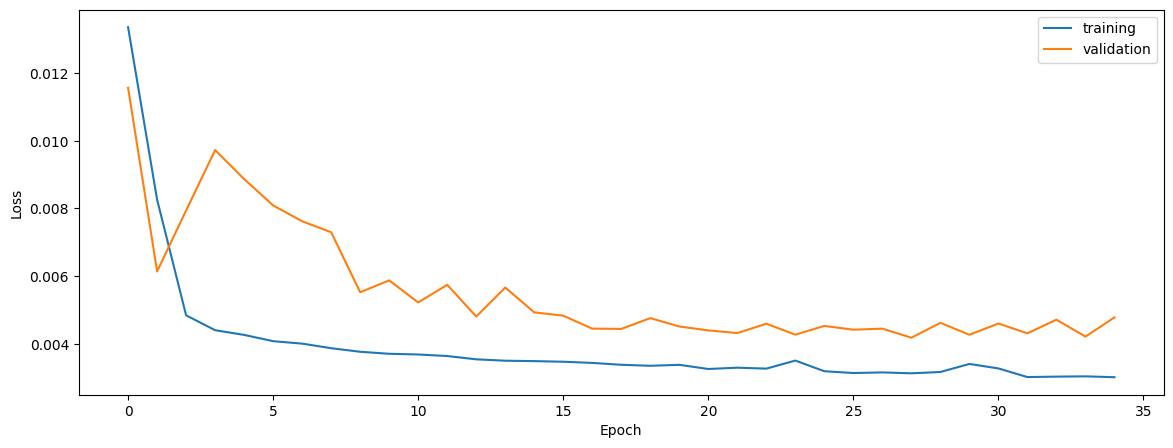

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getPearson, predictInBatches

train_pred = predictInBatches(model,train[0],architecture['batch_size'])
val_pred = predictInBatches(model,val[0],architecture['batch_size'])
test_pred = predictInBatches(model,test[0],architecture['batch_size'])

print('train')
print(getPearson(train[1],train_pred))
print(getPearson(val[1],val_pred))
print(getPearson(test[1],test_pred))

train
0.8629700777419318
0.817752945452865
0.8629728002396628


In [8]:
print('normalized')
print(getPearson(train[1],train_pred))
print(getPearson(val[1],val_pred))
print(getPearson(test[1],test_pred))

normalized
0.8629700777419318
0.817752945452865
0.8629728002396628


In [9]:
print('native')
print(getPearson(train[1][train[2]],train_pred[train[2]]))
print(getPearson(val[1][val[2]],val_pred[val[2]]))
print(getPearson(test[1][test[2]],test_pred[test[2]]))

native
0.8353909087997088
0.7853767758526131
0.8459851310476275


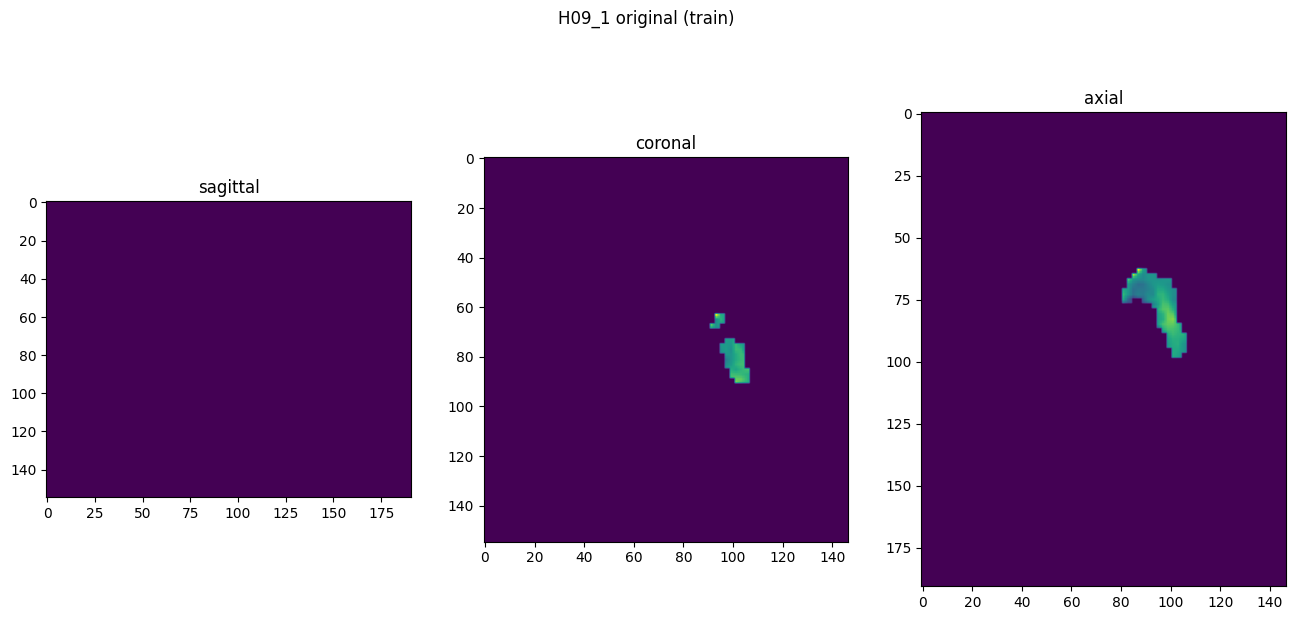

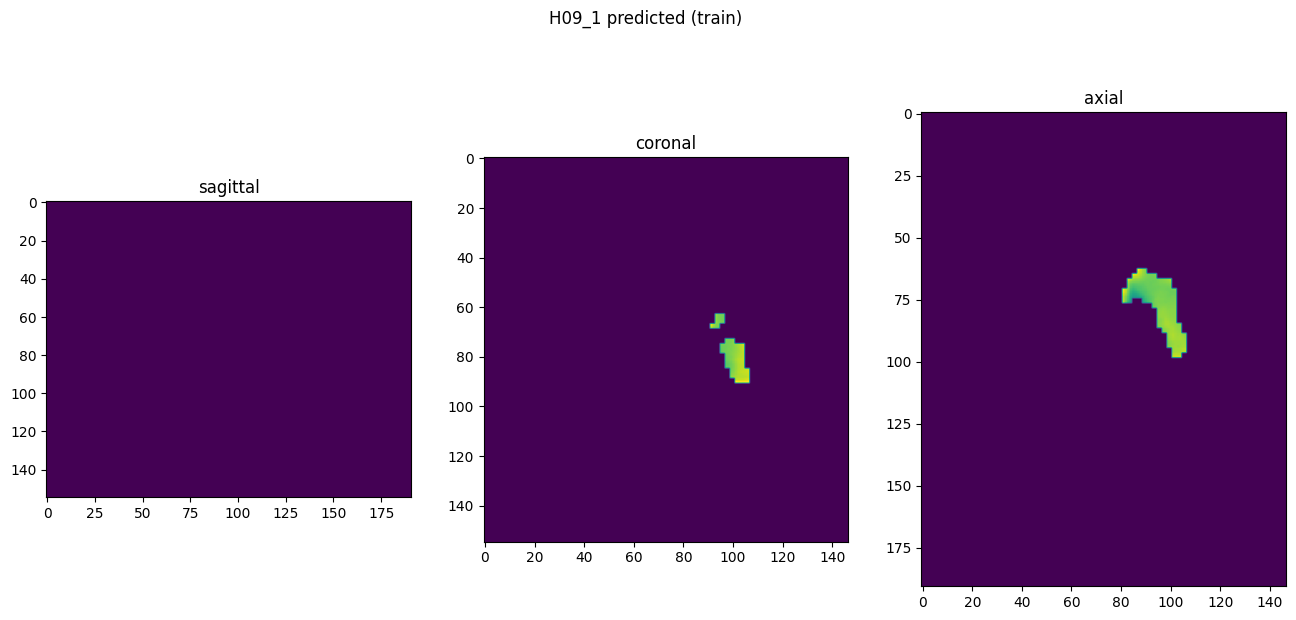

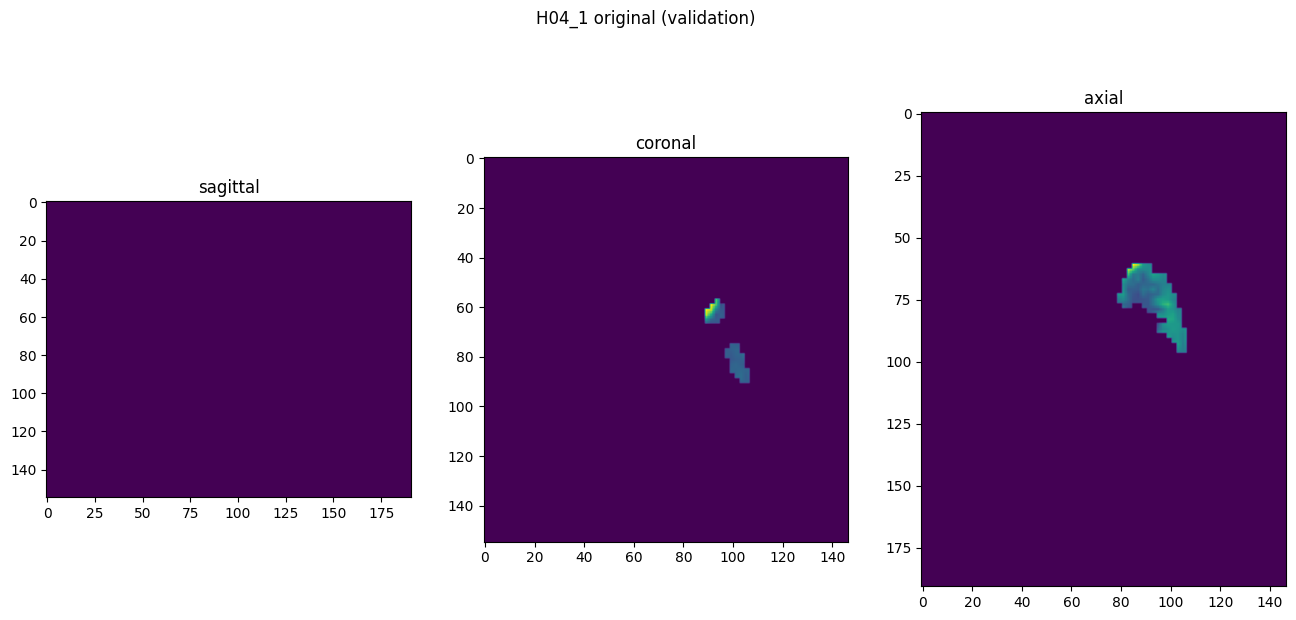

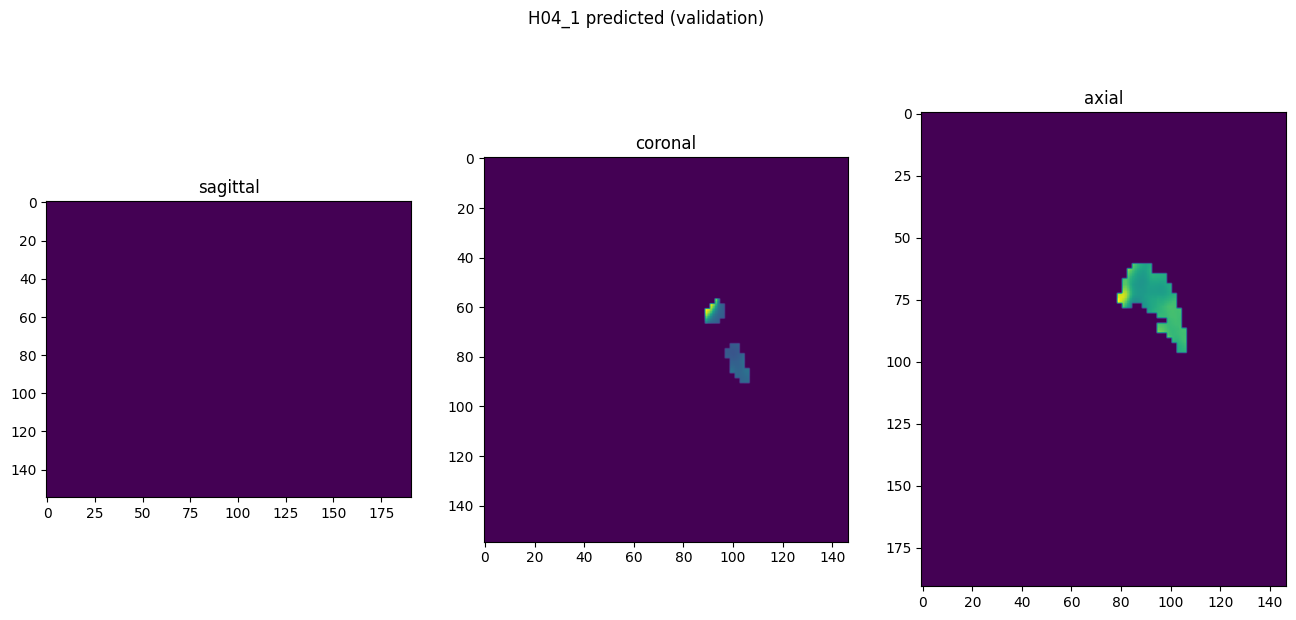

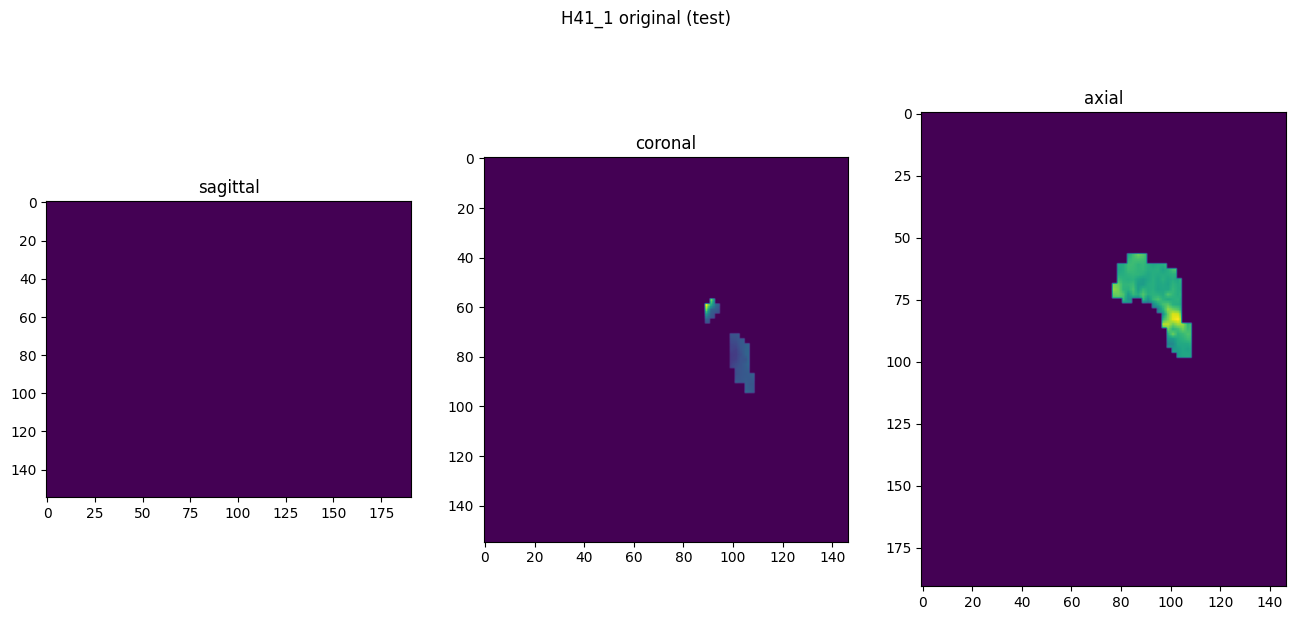

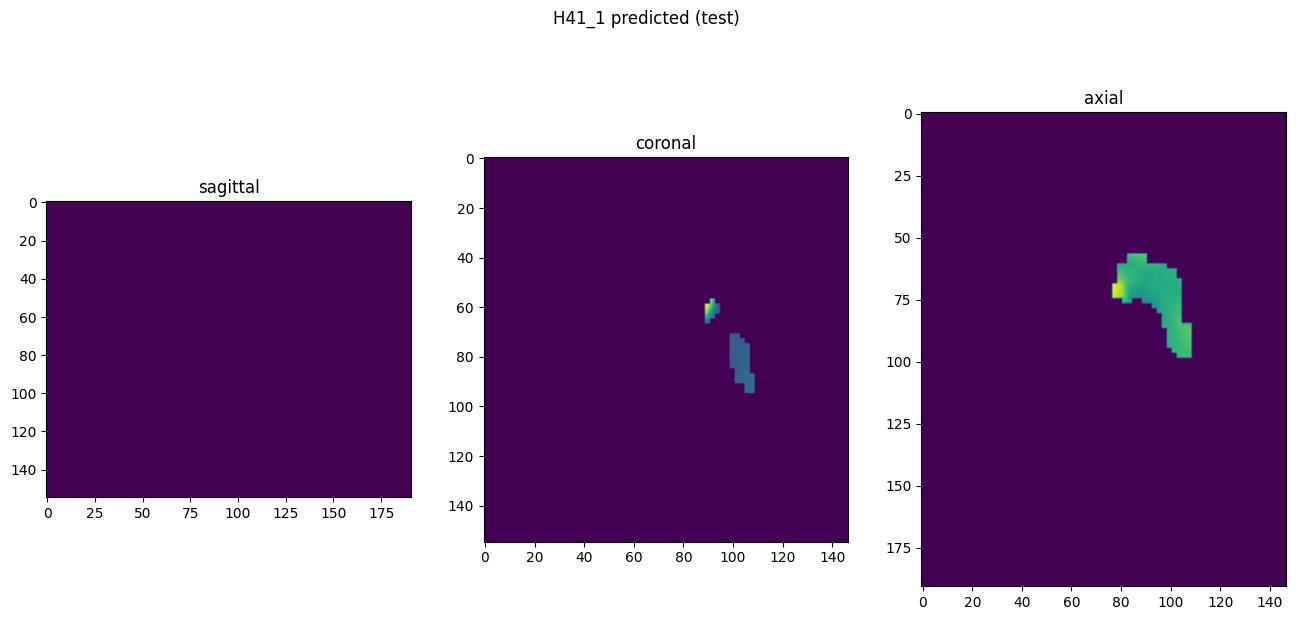

In [10]:
showResults(model, gen, threshold=None, background=False)